# Gender diversity in pop music charts

## Import Libraries

In [2]:
import numpy as np
import pandas as pd

import requests
import re
import json
import csv
import os
from dotenv import load_dotenv
import ast

import pymysql.cursors
from sqlalchemy import create_engine, MetaData
from sqlalchemy.schema import CreateTable
from sqlalchemy import text
import getpass

import time
from datetime import datetime, timedelta
import locale

from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import musicbrainzngs

### Import .env
for Musicbrainz useragent & Last.fm API key

In [3]:
load_dotenv('.env')

True

## Hot 100 Billboard (US 1958-2022)

### Import existing Dataset
Downloaded from https://github.com/HipsterVizNinja/random-data/tree/main/Music/hot-100

In [4]:
hot100_df = pd.read_csv('Hot100_HipsterVizNinja.csv', sep=',')

In [5]:
hot100_df.head()

,chart_position,chart_date,song,performer,song_id,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url
0,84,1990-05-05,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,1,NaN,NaN,84,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...
1,78,1990-05-12,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,2,1.0,84.0,78,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...
2,68,1990-05-19,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,3,2.0,78.0,68,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...
3,60,1990-05-26,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,4,3.0,68.0,60,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...
4,58,1990-06-02,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,5,4.0,60.0,58,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...


In [6]:
hot100_df.tail()

,chart_position,chart_date,song,performer,song_id,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url
336290,99,2001-02-10,www.memory,Alan Jackson,www.memoryAlan Jackson,1.0,15,14.0,89.0,45,99,2000-11-04,https://www.billboard.com/charts/hot-100/2001-...
336291,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,1,NaN,NaN,66,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...
336292,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,2,1.0,66.0,53,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...
336293,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,3,2.0,53.0,47,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...
336294,47,1959-01-03,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,4,3.0,47.0,47,66,1958-12-13,https://www.billboard.com/charts/hot-100/1959-...


In [7]:
hot100_df.shape

(336295, 13)

In [8]:
hot100_df.nunique()

chart_position         100
chart_date            3363
song                 25225
performer            10499
song_id              30444
instance                15
time_on_chart           91
consecutive_weeks       89
previous_week          100
peak_position          100
worst_position         100
chart_debut           3344
chart_url             3363
dtype: int64

### Pre-processing

#### Clean 'song_id'

In [9]:
# Concatenate "song" and "performer" columns to create "song_id"
hot100_df['song_id2'] = hot100_df['song'] + '-' + hot100_df['performer']

# Clean the "song_id" values
hot100_df['song_id2'] = hot100_df['song_id2'].str.strip().str.lower()

hot100_df

,chart_position,chart_date,song,performer,song_id,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url,song_id2
0,84,1990-05-05,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,1,NaN,NaN,84,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
1,78,1990-05-12,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,2,1.0,84.0,78,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
2,68,1990-05-19,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,3,2.0,78.0,68,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
3,60,1990-05-26,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,4,3.0,68.0,60,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
4,58,1990-06-02,"""B"" Girls",Young And Restless,"""B"" GirlsYoung And Restless",1.0,5,4.0,60.0,58,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336290,99,2001-02-10,www.memory,Alan Jackson,www.memoryAlan Jackson,1.0,15,14.0,89.0,45,99,2000-11-04,https://www.billboard.com/charts/hot-100/2001-...,www.memory-alan jackson
336291,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,1,NaN,NaN,66,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...
336292,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,2,1.0,66.0,53,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...
336293,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus...,1.0,3,2.0,53.0,47,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...


In [10]:
hot100_df.nunique()

chart_position         100
chart_date            3363
song                 25225
performer            10499
song_id              30444
instance                15
time_on_chart           91
consecutive_weeks       89
previous_week          100
peak_position          100
worst_position         100
chart_debut           3344
chart_url             3363
song_id2             30435
dtype: int64

In [11]:
# Clean the "song_id" values
hot100_df['song_id'] = hot100_df['song_id'].str.strip().str.lower()
hot100_df.nunique()

chart_position         100
chart_date            3363
song                 25225
performer            10499
song_id              30435
instance                15
time_on_chart           91
consecutive_weeks       89
previous_week          100
peak_position          100
worst_position         100
chart_debut           3344
chart_url             3363
song_id2             30435
dtype: int64

In [12]:
# Now we see that song_id2 and song_id have the same value counts. We can drop the original 'song_id' column
hot100_df.drop('song_id', axis=1, inplace=True)

# Rename 'song_id2' as 'song_id'
hot100_df.rename(columns={'song_id2': 'song_id'}, inplace=True)

hot100_df

,chart_position,chart_date,song,performer,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url,song_id
0,84,1990-05-05,"""B"" Girls",Young And Restless,1.0,1,NaN,NaN,84,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
1,78,1990-05-12,"""B"" Girls",Young And Restless,1.0,2,1.0,84.0,78,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
2,68,1990-05-19,"""B"" Girls",Young And Restless,1.0,3,2.0,78.0,68,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
3,60,1990-05-26,"""B"" Girls",Young And Restless,1.0,4,3.0,68.0,60,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
4,58,1990-06-02,"""B"" Girls",Young And Restless,1.0,5,4.0,60.0,58,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336290,99,2001-02-10,www.memory,Alan Jackson,1.0,15,14.0,89.0,45,99,2000-11-04,https://www.billboard.com/charts/hot-100/2001-...,www.memory-alan jackson
336291,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,1,NaN,NaN,66,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...
336292,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,2,1.0,66.0,53,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...
336293,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,3,2.0,53.0,47,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...


#### #TODO: FUNCTION NEEDS FINE TUNING (misses '&','+', 'w/' in pattern and fails to strip )] in feat. artist) From 'performer', create 'main_artist' and 'artist_featured'

In [13]:
performer_counts = hot100_df['performer'].value_counts()
performer_counts

Taylor Swift                                      1180
Elton John                                         889
Madonna                                            857
Drake                                              832
Kenny Chesney                                      777
                                                  ... 
Fat Joe & Dre Featuring Eminem & Mary J. Blige       1
King Von Featuring Fivio Foreign                     1
Alisan Porter                                        1
Pharrell Williams & Travis Scott                     1
Kimberly Nichole                                     1
Name: performer, Length: 10499, dtype: int64

In [14]:
top_20_performers = performer_counts.head(20)
top_20_performers

Taylor Swift          1180
Elton John             889
Madonna                857
Drake                  832
Kenny Chesney          777
Tim McGraw             739
Keith Urban            674
Stevie Wonder          659
Rod Stewart            657
Mariah Carey           635
Michael Jackson        613
Chicago                607
Rascal Flatts          604
Jason Aldean           592
Billy Joel             588
The Beatles            585
The Rolling Stones     585
Rihanna                575
Aretha Franklin        569
P!nk                   564
Name: performer, dtype: int64

In [15]:
# # FUNCTION TO SEPARATE ARTIST WITH "FEAT." INTO MAIN AND FEATURED ARTISTS
# # Newer version, keywords back into the function - might still be a bit agressive, but best compromise found to optimize clean main-artist unique count
# 
# def clean_artist_features(artist):
#     # define pattern, case-insensitive + must exclude cases
#     # when pattern is directly followed by other letters (i.e. Andy, Andrew, etc)
#     pattern = re.compile(r'\b(?:feat\.?|featuring|introducing|co-starring|and|&|with|,|\+)\b', re.IGNORECASE)
#     # plan for leftover brackets and parenthesis after featured artist is stripped:
#     parentheses_pattern_main = re.compile(r'\s*\($')
#     brackets_pattern_main = re.compile(r'\s*\[$')
#     parentheses_pattern_featured = re.compile(r'([^()\[\]]+)\s*[)\]]+$')
# 
#     match = re.search(pattern, artist)
#     if match:
#         cleaned_artist_main = artist[:match.start()].strip()
#         cleaned_artist_main = re.sub(parentheses_pattern_main, '', cleaned_artist_main).strip()
#         cleaned_artist_main = re.sub(brackets_pattern_main, '', cleaned_artist_main).strip()
#         featured_artist = re.sub(pattern, '', artist[match.end():]).strip('. ').lstrip('uring ')
#         return cleaned_artist_main, featured_artist
#     else:
#         return artist, ''
# 
# hot100_df[['main_artist', 'artist_featured']] = hot100_df['performer'].apply(clean_artist_features).apply(pd.Series)
# 
# hot100_df

In [16]:
# Commas, &, +, w/ can still be found in main-artist.
# newer version of the function:

def clean_artist_features(artist):
    #pattern = re.compile(r'(?i)\b(?:feat\.?|featuring|introducing|co-starring|and|with|\+|,?\s*&\s*)\b')
    #pattern = re.compile(r'(?i)\b(?:feat\.?|featuring|introducing|co-starring)\b(?![a-z0-9])|'
    #                 r'\b(?:and|with|w\/|\+|,?\s*&\s*)\b(?![a-z0-9])') # NO THIS RETURNS 8154 MAIN-ARTIST
    #pattern = re.compile(r'(?i)\b(?:feat\.?|featuring|introducing|co-starring|and|with|w\/|\+|,\s|&\s)\b') # 8036, strips commas without moving featured artist, still & remaining
    pattern = re.compile(r'(?i)\b(?:feat\.?|featuring|introducing|co-starring|and|with|w\/|\+|,?\s*&\s*)\b') # BEST RESULT WITH 7550 MAIN-ARTISTS, BUT STILL ,&+ in main-artists
    parentheses_pattern_main = re.compile(r'\s*\($')
    brackets_pattern_main = re.compile(r'\s*\[$')
    parentheses_pattern_featured = re.compile(r'([^()\[\]]+)\s*[)\]]+$')

    match = re.search(pattern, artist)
    if match:
        cleaned_artist_main = artist[:match.start()].strip()
        cleaned_artist_main = re.sub(parentheses_pattern_main, '', cleaned_artist_main).strip()
        cleaned_artist_main = re.sub(brackets_pattern_main, '', cleaned_artist_main).strip()
        featured_artist = re.sub(pattern, '', artist[match.end():]).strip('. ').lstrip('uring ')
        return cleaned_artist_main, featured_artist
    else:
        return artist, ''

hot100_df[['main_artist', 'artist_featured']] = hot100_df['performer'].apply(clean_artist_features).apply(pd.Series)

hot100_df

,chart_position,chart_date,song,performer,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url,song_id,main_artist,artist_featured
0,84,1990-05-05,"""B"" Girls",Young And Restless,1.0,1,NaN,NaN,84,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless",Young,Restless
1,78,1990-05-12,"""B"" Girls",Young And Restless,1.0,2,1.0,84.0,78,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless",Young,Restless
2,68,1990-05-19,"""B"" Girls",Young And Restless,1.0,3,2.0,78.0,68,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless",Young,Restless
3,60,1990-05-26,"""B"" Girls",Young And Restless,1.0,4,3.0,68.0,60,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless",Young,Restless
4,58,1990-06-02,"""B"" Girls",Young And Restless,1.0,5,4.0,60.0,58,84,1990-05-05,https://www.billboard.com/charts/hot-100/1990-...,"""b"" girls-young and restless",Young,Restless
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336290,99,2001-02-10,www.memory,Alan Jackson,1.0,15,14.0,89.0,45,99,2000-11-04,https://www.billboard.com/charts/hot-100/2001-...,www.memory-alan jackson,Alan Jackson,
336291,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,1,NaN,NaN,66,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...,Augie Rios,
336292,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,2,1.0,66.0,53,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...,Augie Rios,
336293,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1.0,3,2.0,53.0,47,66,1958-12-13,https://www.billboard.com/charts/hot-100/1958-...,¿dònde està santa claus? (where is santa claus...,Augie Rios,


In [17]:
# STILL 8152 main artists and too many issues
# 
# def clean_artist_features(artist, keywords):
#     pattern = re.compile(r'\b(?:{})\b'.format('|'.join(keywords)), re.IGNORECASE)
#     parentheses_pattern_main = re.compile(r'\s*\($')
#     brackets_pattern_main = re.compile(r'\s*\[$')
#     parentheses_pattern_featured = re.compile(r'([^()\[\]]+)\s*[)\]]+$')
# 
#     match = re.search(pattern, artist)
#     if match:
#         cleaned_artist_main = artist[:match.start()].strip()
#         cleaned_artist_main = re.sub(parentheses_pattern_main, '', cleaned_artist_main).strip()
#         cleaned_artist_main = re.sub(brackets_pattern_main, '', cleaned_artist_main).strip()
#         featured_artist = re.sub(pattern, '', artist[match.start():]).strip('. ').lstrip('uring ')
#         return cleaned_artist_main, featured_artist
#     else:
#         return artist, ''
# 
# keywords = ['feat', 'feat\.', 'featuring', 'introducing', 'co-starring', 'and', '&', 'with', r'w\/', r',', r'\+']
# 
# hot100_df[['main_artist', 'artist_featured']] = hot100_df['performer'].apply(clean_artist_features, keywords=keywords).apply(pd.Series)


In [18]:
#DISPLAY ONLY ROWS WITH FEAT
hot100_df.loc[hot100_df['performer'].str.contains('feat')]

,chart_position,chart_date,song,performer,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,chart_debut,chart_url,song_id,main_artist,artist_featured
1306,94,1964-01-25,(It's No) Sin,The Duprees featuring Joey Vann,1.0,1,NaN,NaN,94,94,1964-01-25,https://www.billboard.com/charts/hot-100/1964-...,(it's no) sin-the duprees featuring joey vann,The Duprees,Joey Vann
1307,82,1964-02-01,(It's No) Sin,The Duprees featuring Joey Vann,1.0,2,1.0,94.0,82,94,1964-01-25,https://www.billboard.com/charts/hot-100/1964-...,(it's no) sin-the duprees featuring joey vann,The Duprees,Joey Vann
1308,74,1964-02-08,(It's No) Sin,The Duprees featuring Joey Vann,1.0,3,2.0,82.0,74,94,1964-01-25,https://www.billboard.com/charts/hot-100/1964-...,(it's no) sin-the duprees featuring joey vann,The Duprees,Joey Vann
1309,88,1964-02-15,(It's No) Sin,The Duprees featuring Joey Vann,1.0,4,3.0,74.0,74,94,1964-01-25,https://www.billboard.com/charts/hot-100/1964-...,(it's no) sin-the duprees featuring joey vann,The Duprees,Joey Vann
1310,84,1964-02-22,(It's No) Sin,The Duprees featuring Joey Vann,1.0,5,4.0,88.0,74,94,1964-01-25,https://www.billboard.com/charts/hot-100/1964-...,(it's no) sin-the duprees featuring joey vann,The Duprees,Joey Vann
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320786,48,1963-09-07,Why Don't You Believe Me,The Duprees featuring Joey Vann,1.0,3,2.0,59.0,48,70,1963-08-24,https://www.billboard.com/charts/hot-100/1963-...,why don't you believe me-the duprees featuring...,The Duprees,Joey Vann
320787,40,1963-09-14,Why Don't You Believe Me,The Duprees featuring Joey Vann,1.0,4,3.0,48.0,40,70,1963-08-24,https://www.billboard.com/charts/hot-100/1963-...,why don't you believe me-the duprees featuring...,The Duprees,Joey Vann
320788,37,1963-09-21,Why Don't You Believe Me,The Duprees featuring Joey Vann,1.0,5,4.0,40.0,37,70,1963-08-24,https://www.billboard.com/charts/hot-100/1963-...,why don't you believe me-the duprees featuring...,The Duprees,Joey Vann
320789,39,1963-09-28,Why Don't You Believe Me,The Duprees featuring Joey Vann,1.0,6,5.0,37.0,37,70,1963-08-24,https://www.billboard.com/charts/hot-100/1963-...,why don't you believe me-the duprees featuring...,The Duprees,Joey Vann


In [19]:
hot100_df['main_artist'].value_counts()
#Now we have only 7550 (previously 8152) unique main artists (down from 10499 performers)

Drake                 1676
Taylor Swift          1300
Elton John            1003
Elvis Presley          995
Rihanna                925
                      ... 
RiceGum                  1
ROCKMAFIA                1
The Postal Service       1
Meghan Linsey            1
Larray                   1
Name: main_artist, Length: 7550, dtype: int64

In [20]:
empty_main_artist_rows = hot100_df[hot100_df['main_artist'].str.strip() == '']
unique_performers = empty_main_artist_rows['performer'].unique()
print(unique_performers)
#No more empty main-artists after fine-tuning the function

[]


In [21]:
hot100_df['artist_featured'].value_counts()
#And 2614 unique featured artists (that would themselves require more cleaning)

                                 272769
Drake                               904
His Orchestra                       810
Lil Wayne                           660
Nicki Minaj                         603
                                  ...  
Lamb                                  1
Chris Brown  Yung Bleu                1
J. Cole  Kenny MasonSheck Wes         1
Doodie Lo                             1
Mitchell Hope                         1
Name: artist_featured, Length: 2614, dtype: int64

In [22]:
nan_rows = hot100_df[hot100_df['main_artist'].isna()]
columns_to_display = ['performer', 'main_artist', 'artist_featured']
displayed_rows = nan_rows.loc[:, columns_to_display]
displayed_rows

,performer,main_artist,artist_featured


In [23]:
longest_artist_names = sorted(hot100_df['main_artist'].unique(), key=len, reverse=True)
longest_artist_names

['Dove Cameron, Sofia Carson, Booboo Stewart, Cameron Boyce, Thomas Doherty, China Anne McClain',
 'Carolina Gaitan, Mauro Castillo, Adassa, Rhenzy Feliz, Diane Guerrero, Stephanie Beatriz',
 'Kanye West, Gucci Mane, Big Sean, 2 Chainz, Travi$ Scott, Yo Gotti, Quavo, Desiigner',
 'Stephanie Beatriz, Olga Merediz, John Leguizamo, Adassa, Maluma',
 'John Lennon/Plastic Ono Band Yoko Ono/Plastic Ono Band',
 'Ozuna x Daddy Yankee x J Balvin x Farruko x Anuel AA',
 'The Tommy Dorsey Orchestra Starring Warren Covington',
 'Nio Garcia x Anuel AA x Myke Towers x Brray x Juanka',
 'Casper Magico, Nio Garcia, Darell, Nicky Jam, Ozuna',
 'Stars On 54: Ultra Nate, Amber, Jocelyn Enriquez',
 "Shaquille O'Neal, Ice Cube, B Real, Peter Gunz",
 'The Presidents Of The United States Of America',
 'Hugh Jackman, Keala Settle, Zac Efron, Zendaya',
 'The Partridge Family Starring Shirley Jones',
 'Sofia Carson, Cameron Boyce, Booboo Stewart',
 'Dove Cameron, Cameron Boyce, Booboo Stewart',
 'The London Sym

#### Data types

In [24]:
hot100_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336295 entries, 0 to 336294
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   chart_position     336295 non-null  int64  
 1   chart_date         336295 non-null  object 
 2   song               336295 non-null  object 
 3   performer          336295 non-null  object 
 4   instance           336295 non-null  float64
 5   time_on_chart      336295 non-null  int64  
 6   consecutive_weeks  302987 non-null  float64
 7   previous_week      302987 non-null  float64
 8   peak_position      336295 non-null  int64  
 9   worst_position     336295 non-null  int64  
 10  chart_debut        336295 non-null  object 
 11  chart_url          336295 non-null  object 
 12  song_id            336295 non-null  object 
 13  main_artist        336295 non-null  object 
 14  artist_featured    336295 non-null  object 
dtypes: float64(3), int64(4), object(8)
memory usage: 38

In [25]:
hot100_df.isnull().sum()

chart_position           0
chart_date               0
song                     0
performer                0
instance                 0
time_on_chart            0
consecutive_weeks    33308
previous_week        33308
peak_position            0
worst_position           0
chart_debut              0
chart_url                0
song_id                  0
main_artist              0
artist_featured          0
dtype: int64

In [26]:
#Convert float columns to int

#those columns have NA so can't convert to int:
# columns_to_int = ['consecutive_weeks', 'previous_week']

hot100_df['instance'] = hot100_df['instance'].astype(int)
hot100_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336295 entries, 0 to 336294
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   chart_position     336295 non-null  int64  
 1   chart_date         336295 non-null  object 
 2   song               336295 non-null  object 
 3   performer          336295 non-null  object 
 4   instance           336295 non-null  int64  
 5   time_on_chart      336295 non-null  int64  
 6   consecutive_weeks  302987 non-null  float64
 7   previous_week      302987 non-null  float64
 8   peak_position      336295 non-null  int64  
 9   worst_position     336295 non-null  int64  
 10  chart_debut        336295 non-null  object 
 11  chart_url          336295 non-null  object 
 12  song_id            336295 non-null  object 
 13  main_artist        336295 non-null  object 
 14  artist_featured    336295 non-null  object 
dtypes: float64(2), int64(5), object(8)
memory usage: 38

In [769]:
#Convert week columns to datetype
hot100_df['chart_date'] = pd.to_datetime(hot100_df['chart_date'], format='%Y-%m-%d')
hot100_df['chart_debut'] = pd.to_datetime(hot100_df['chart_debut'], format='%Y-%m-%d')
hot100_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336295 entries, 0 to 336294
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   chart_position     336295 non-null  int64         
 1   chart_date         336295 non-null  datetime64[ns]
 2   song               336295 non-null  object        
 3   performer          336295 non-null  object        
 4   instance           336295 non-null  int64         
 5   time_on_chart      336295 non-null  int64         
 6   consecutive_weeks  302987 non-null  float64       
 7   previous_week      302987 non-null  float64       
 8   peak_position      336295 non-null  int64         
 9   worst_position     336295 non-null  int64         
 10  chart_debut        336295 non-null  datetime64[ns]
 11  chart_url          336295 non-null  object        
 12  song_id            336295 non-null  object        
 13  main_artist        336295 non-null  object  

## Top50 (1984-1998) & Top100 (FR 1998-2020)

### Scrape single charts
*(Crawling and export part #commented below so as not to run again!)*

In [27]:
#DEFINE WEEK_ID LIST USED IN URL

start_year = 1984
end_year = 2020

week_ids = []

for year in range(start_year, end_year + 1):
    if year == start_year:
        start_week = 44  # Starting week for the first year
    else:
        start_week = 1   # Starting week for subsequent years
        
    if year == end_year:
        end_week = 51  # Ending week for the last year
    else:
        end_week = 53  # Ending week for other years

    for week in range(start_week, end_week + 1):
        week_id = "{:02d}{:02d}".format(year % 100, week)
        week_ids.append(week_id)

print(week_ids)

['8444', '8445', '8446', '8447', '8448', '8449', '8450', '8451', '8452', '8453', '8501', '8502', '8503', '8504', '8505', '8506', '8507', '8508', '8509', '8510', '8511', '8512', '8513', '8514', '8515', '8516', '8517', '8518', '8519', '8520', '8521', '8522', '8523', '8524', '8525', '8526', '8527', '8528', '8529', '8530', '8531', '8532', '8533', '8534', '8535', '8536', '8537', '8538', '8539', '8540', '8541', '8542', '8543', '8544', '8545', '8546', '8547', '8548', '8549', '8550', '8551', '8552', '8553', '8601', '8602', '8603', '8604', '8605', '8606', '8607', '8608', '8609', '8610', '8611', '8612', '8613', '8614', '8615', '8616', '8617', '8618', '8619', '8620', '8621', '8622', '8623', '8624', '8625', '8626', '8627', '8628', '8629', '8630', '8631', '8632', '8633', '8634', '8635', '8636', '8637', '8638', '8639', '8640', '8641', '8642', '8643', '8644', '8645', '8646', '8647', '8648', '8649', '8650', '8651', '8652', '8653', '8701', '8702', '8703', '8704', '8705', '8706', '8707', '8708', '8709',

In [28]:
# FUNCTION FOR PARSING THROUGH PAGE CONTENT AND STORING CHART DETAILS

def scrape_chart_details(week_id, FRcharts_df, soup=None, soup2=None):
    if soup2 is not None:
        soup = soup2

    #Create a Dataframe to store the given week info
    week_df = pd.DataFrame(columns=FRcharts_df.columns)

    # Scrape the year and week date
    year_select = soup.find("option", selected=True)
    
    # Handle error if the page for this week ID doesn't exist (Redirection to 404.php page doesn't allow us to catch a 404 response)
    if year_select is None:
        print("Error Week #", week_id, "(year not found)")
        return week_df
    
    year = year_select.text.strip()

    week_select = soup.find("select", attrs={"name": "semaine"})
    week_option = week_select.find("option", selected=True)
    week_date = week_option.text.strip()

    # Scrape the chart details
    chart_data = soup.find_all("div", class_="b572")
    for entry in chart_data:
        try:
            position = entry.find("div", class_="c1_td2").text.strip()
            
            # Find the position evolution in all four possible classes
            position_trends = ["entry", "egal", "up", "down"]
            position_evolution = ""
            for trend in position_trends:
                evolution_elem = entry.find("font", class_=trend)
                if evolution_elem:
                    position_evolution = evolution_elem.text.strip()
                    break #exit the loop after finding the position evolution

            artist = entry.find("font", class_="noir13b").text.strip()
            song_title = entry.find("font", class_="noir11").text.strip()

        except AttributeError:
            print("Error scraping data for an entry. Week #", week_id, " Skipping. Position #", position)

        # Add the scraped data to the week's DataFrame using pd.concat (append will be deprecated from future Pandas version)
        entry_df = pd.DataFrame(
             [[position, position_evolution, artist, song_title, year, week_date, week_id]],
             columns=FRcharts_df.columns)
        week_df = pd.concat([week_df, entry_df], ignore_index=True)

    # Export the week's Dataframe to csv, append the csv if it exists without column names
    # Append the global DF if week is not empty
    if not week_df.empty:
        week_df.to_csv('top50_in_progress.csv', mode='a', header=not os.path.isfile('top50_in_progress.csv')) #index=False, mode: 'w' (overwrite) / 'a' (append)
#        FRcharts_df = pd.concat([FRcharts_df, week_df])     

        # Feedback for Scraping status monitoring
        print("Scraped #", week_id,": ", week_date)

    return week_df

In [21]:
#CRAWLING THROUGH GIVEN PAGES AND RETURNING REQUEST STATUS AND DATAFRAME

#########################################

# COMMENTED OUT SO AS NOT TO CRAWL AGAIN

#########################################

# # Define Dataframe first outside the function
# FRcharts_df = pd.DataFrame(
#     columns=["Position", "Position Evolution", "Artist", "Song Title", "Year", "Week", "URL Week ID"])
#         
# #def scrape_chart_pages(start_week_ID, end_week_ID, FRcharts_df):
# base_url = "https://www.chartsinfrance.net"
# page_statuses = {}  # Dictionary to store page statuses
# 
# for week_id in week_ids:
#     FRcharts_url = f"{base_url}/charts/{week_id}/singles.php"
#     
#     # Send a GET request to the URL and check if it received a response
#     delay = 0.5
#     
#     try:
#         response = requests.get(FRcharts_url)
#         page_statuses[week_id] = response.status_code  # Store the request status in page statuses
#         response.raise_for_status()  # Raise an exception if an HTTP error occurred
#     except requests.exceptions.HTTPError as e:
#         print(f"URL not found: {FRcharts_url}")
#         continue  # Skip to the next iteration of the loop
#     # Parse the HTML content
#     soup = BeautifulSoup(response.content, "html.parser")
# 
#     FRcharts_df = pd.concat([FRcharts_df, scrape_chart_details(week_id, FRcharts_df, soup=soup)])
# 
#     # Check if a second page exists
#     pagination_div = soup.find("div", class_="pagination")
#     if pagination_div:
#         second_page_link = pagination_div.find("a", href=True)
#         if second_page_link:
#             page2_url = base_url + second_page_link["href"]
#             try:
#                 response2 = requests.get(page2_url)
#                 page_statuses[week_id,2] = response2.status_code  # Store the request status in page statuses
#                 response2.raise_for_status()  # Raise an exception if an HTTP error occurred
#                 if response2.status_code == 200:
#                     soup2 = BeautifulSoup(response2.content, "html.parser")
#                     FRcharts_df = pd.concat([FRcharts_df, scrape_chart_details(week_id, FRcharts_df, soup2=soup2)])
#             except requests.exceptions.HTTPError as e:
#                 print(f"URL not found: {page2_url}")
#                 continue  # Skip to the next iteration of the loop
# 
#     time.sleep(delay)
# 
# FRcharts_df.reset_index(drop=True, inplace=True)
# FRcharts_df.index = FRcharts_df.index + 1
# FRcharts_df.to_csv('top50.csv', mode='a', header=not os.path.isfile('top50.csv')) #index=False, mode: 'w' (overwrite) / 'a' (append)

#page_statuses
#FRcharts_df # 152551 rows × 7 columns


### Import scraped French Top 50

In [29]:
FRcharts_df = pd.read_csv('top50.csv', sep=',', index_col=0)

In [30]:
FRcharts_df


,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID
1,1,Entrée,Peter et Sloane,"Besoin de rien, envie de toi",1984,Semaine du 26 octobre 1984,8444
2,2,Entrée,Cookie Dingler,Femme libérée,1984,Semaine du 26 octobre 1984,8444
3,3,Entrée,Scorpions,Still Loving You,1984,Semaine du 26 octobre 1984,8444
4,4,Entrée,Chris De Burgh,High On Emotion,1984,Semaine du 26 octobre 1984,8444
5,5,Entrée,Stevie Wonder,I Just Called To Say I Love You,1984,Semaine du 26 octobre 1984,8444
...,...,...,...,...,...,...,...
152547,96,Entrée,Bon Entendeur,Le temps est bon,2020,Semaine du 11 décembre 2020,2051
152548,97,Entrée,Patrick Fiori,Les gens qu'on aime,2020,Semaine du 11 décembre 2020,2051
152549,98,-28,Jean-Louis Murat,Baby Love D.c.,2020,Semaine du 11 décembre 2020,2051
152550,99,Entrée,Barbara Pravi,Voilà,2020,Semaine du 11 décembre 2020,2051


### Pre-processing

#### Create song_id

In [31]:
# Concatenate "song_title" and "artist" columns to create "song_id"
FRcharts_df['song_id'] = FRcharts_df['Song Title'] + '-' + FRcharts_df['Artist']

# Clean the "song_id" values
FRcharts_df['song_id'] = FRcharts_df['song_id'].str.strip().str.lower()

FRcharts_df

,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id
1,1,Entrée,Peter et Sloane,"Besoin de rien, envie de toi",1984,Semaine du 26 octobre 1984,8444,"besoin de rien, envie de toi-peter et sloane"
2,2,Entrée,Cookie Dingler,Femme libérée,1984,Semaine du 26 octobre 1984,8444,femme libérée-cookie dingler
3,3,Entrée,Scorpions,Still Loving You,1984,Semaine du 26 octobre 1984,8444,still loving you-scorpions
4,4,Entrée,Chris De Burgh,High On Emotion,1984,Semaine du 26 octobre 1984,8444,high on emotion-chris de burgh
5,5,Entrée,Stevie Wonder,I Just Called To Say I Love You,1984,Semaine du 26 octobre 1984,8444,i just called to say i love you-stevie wonder
...,...,...,...,...,...,...,...,...
152547,96,Entrée,Bon Entendeur,Le temps est bon,2020,Semaine du 11 décembre 2020,2051,le temps est bon-bon entendeur
152548,97,Entrée,Patrick Fiori,Les gens qu'on aime,2020,Semaine du 11 décembre 2020,2051,les gens qu'on aime-patrick fiori
152549,98,-28,Jean-Louis Murat,Baby Love D.c.,2020,Semaine du 11 décembre 2020,2051,baby love d.c.-jean-louis murat
152550,99,Entrée,Barbara Pravi,Voilà,2020,Semaine du 11 décembre 2020,2051,voilà-barbara pravi


In [32]:
FRcharts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152551 entries, 1 to 152551
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Position            152551 non-null  int64 
 1   Position Evolution  152551 non-null  object
 2   Artist              152548 non-null  object
 3   Song Title          152548 non-null  object
 4   Year                152551 non-null  int64 
 5   Week                152551 non-null  object
 6   URL Week ID         152551 non-null  int64 
 7   song_id             152548 non-null  object
dtypes: int64(3), object(5)
memory usage: 10.5+ MB


#### From 'Week' to 'chart_date'

In [33]:
# Set the French locale
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Convert the 'Week Date' column to datetime format
FRcharts_df['chart_date'] = pd.to_datetime(FRcharts_df['Week'], format='Semaine du %d %B %Y')

FRcharts_df

,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id,chart_date
1,1,Entrée,Peter et Sloane,"Besoin de rien, envie de toi",1984,Semaine du 26 octobre 1984,8444,"besoin de rien, envie de toi-peter et sloane",1984-10-26
2,2,Entrée,Cookie Dingler,Femme libérée,1984,Semaine du 26 octobre 1984,8444,femme libérée-cookie dingler,1984-10-26
3,3,Entrée,Scorpions,Still Loving You,1984,Semaine du 26 octobre 1984,8444,still loving you-scorpions,1984-10-26
4,4,Entrée,Chris De Burgh,High On Emotion,1984,Semaine du 26 octobre 1984,8444,high on emotion-chris de burgh,1984-10-26
5,5,Entrée,Stevie Wonder,I Just Called To Say I Love You,1984,Semaine du 26 octobre 1984,8444,i just called to say i love you-stevie wonder,1984-10-26
...,...,...,...,...,...,...,...,...,...
152547,96,Entrée,Bon Entendeur,Le temps est bon,2020,Semaine du 11 décembre 2020,2051,le temps est bon-bon entendeur,2020-12-11
152548,97,Entrée,Patrick Fiori,Les gens qu'on aime,2020,Semaine du 11 décembre 2020,2051,les gens qu'on aime-patrick fiori,2020-12-11
152549,98,-28,Jean-Louis Murat,Baby Love D.c.,2020,Semaine du 11 décembre 2020,2051,baby love d.c.-jean-louis murat,2020-12-11
152550,99,Entrée,Barbara Pravi,Voilà,2020,Semaine du 11 décembre 2020,2051,voilà-barbara pravi,2020-12-11


In [34]:
FRcharts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152551 entries, 1 to 152551
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Position            152551 non-null  int64         
 1   Position Evolution  152551 non-null  object        
 2   Artist              152548 non-null  object        
 3   Song Title          152548 non-null  object        
 4   Year                152551 non-null  int64         
 5   Week                152551 non-null  object        
 6   URL Week ID         152551 non-null  int64         
 7   song_id             152548 non-null  object        
 8   chart_date          152551 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 11.6+ MB


#### Handle numerical columns *if needed*

In [28]:
# Originally needed to convert some columns to numeric, but when importing the CSV,
# they are now automatically numerical

# columns_to_numeric = ['Position', 'Year', 'URL Week ID']
# 
# # Convert the columns to numeric
# FRcharts_df[columns_to_numeric] = FRcharts_df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')
# 
# # Check the data types
# print(FRcharts_df[columns_to_numeric].dtypes)

#### Handle Missing values in Artist / Song Title / song_id

In [35]:
missing_entries = FRcharts_df.loc[FRcharts_df['Artist'].isna() | FRcharts_df['Song Title'].isna()]
print(missing_entries)

        Position Position Evolution Artist Song Title  Year  \
97762         11                 +1    NaN        NaN  2010   
98104         53             Entrée    NaN        NaN  2010   
107706        55             Entrée    NaN        NaN  2012   

                            Week  URL Week ID song_id chart_date  
97762   Semaine du 23 avril 2010         1017     NaN 2010-04-23  
98104     Semaine du 14 mai 2010         1020     NaN 2010-05-14  
107706   Semaine du 09 mars 2012         1211     NaN 2012-03-09  


In [36]:
# Identifying a NAN in 11th position on week 1017. Supposed to be +1 compared to prev week, so filling up with #12 of week 1016.
artist_value = 'Ke$ha'
song_title_value = 'TiK ToK'
song_id_value = (song_title_value + '-' + artist_value).strip().lower()

# Fill the NaN values in row 97762
FRcharts_df.loc[97762, 'Artist'] = artist_value
FRcharts_df.loc[97762, 'Song Title'] = song_title_value
FRcharts_df.loc[97762, 'song_id'] = song_id_value

In [37]:
# Identifying and filling up NAN in row 98104

artist_value = 'Divers'
song_title_value = 'Hymne Brésil'
song_id_value = (song_title_value + '-' + artist_value).strip().lower()

# Fill the NaN values in row 97762
FRcharts_df.loc[98104, 'Artist'] = artist_value
FRcharts_df.loc[98104, 'Song Title'] = song_title_value
FRcharts_df.loc[98104, 'song_id'] = song_id_value

In [38]:
print(FRcharts_df.loc[98104])


Position                                  53
Position Evolution                    Entrée
Artist                                Divers
Song Title                      Hymne Brésil
Year                                    2010
Week                  Semaine du 14 mai 2010
URL Week ID                             1020
song_id                  hymne brésil-divers
chart_date               2010-05-14 00:00:00
Name: 98104, dtype: object


In [39]:
print(missing_entries)

        Position Position Evolution Artist Song Title  Year  \
97762         11                 +1    NaN        NaN  2010   
98104         53             Entrée    NaN        NaN  2010   
107706        55             Entrée    NaN        NaN  2012   

                            Week  URL Week ID song_id chart_date  
97762   Semaine du 23 avril 2010         1017     NaN 2010-04-23  
98104     Semaine du 14 mai 2010         1020     NaN 2010-05-14  
107706   Semaine du 09 mars 2012         1211     NaN 2012-03-09  


Note we still have 1 unidentified song / artist / song_id in our dataset (Index 107706)

#### From 'Artist' to 'main_artist' and 'artist_featured'

In [40]:
FR_artist_counts = FRcharts_df['Artist'].value_counts()

In [41]:
FR_artist_counts
#5322 artists

Johnny Hallyday    1088
Mylène Farmer      1009
Madonna             977
Rihanna             807
Maître Gims         796
                   ... 
Måns Zelmerlöw        1
Solomon Burke         1
Joe Bel               1
Severija              1
Barbara Pravi         1
Name: Artist, Length: 5322, dtype: int64

In [42]:
# ADAPT FUNCTION FOR CLEANING FEAT ARTISTS
# FOR ERROR HANDLING (OF MISSING VALUE)
 
def clean_artist_features(artist):
    if pd.isna(artist):
        return '', ''  # Return empty strings for NaN values
    
    keywords = ['feat', 'feat\.', 'featuring']
    pattern = re.compile(r'|'.join(keywords), re.IGNORECASE)
    parentheses_pattern_main = re.compile(r'\s*\($')
    brackets_pattern_main = re.compile(r'\s*\[$')
    parentheses_pattern_featured = re.compile(r'([^()\[\]]+)\s*[)\]]+$')

    match = re.search(pattern, artist)
    if match:
        cleaned_artist_main = artist[:match.start()].strip()
        cleaned_artist_main = re.sub(parentheses_pattern_main, '', cleaned_artist_main).strip()
        cleaned_artist_main = re.sub(brackets_pattern_main, '', cleaned_artist_main).strip()
        featured_artist = re.sub(pattern, '', artist[match.end():]).strip('. ').lstrip('uring ')
        return cleaned_artist_main, featured_artist
    else:
        return artist, ''  # Return the original artist and an empty string if no featured artist is found

In [43]:
# CALL THE FUNCTION TO CREATE MAIN AND FEATURED ARTISTS COLUMNS AND DISPLAY RESULTS

FRcharts_df[['main_artist', 'artist_featured']] = FRcharts_df['Artist'].apply(clean_artist_features).apply(pd.Series)

FRcharts_df

,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id,chart_date,main_artist,artist_featured
1,1,Entrée,Peter et Sloane,"Besoin de rien, envie de toi",1984,Semaine du 26 octobre 1984,8444,"besoin de rien, envie de toi-peter et sloane",1984-10-26,Peter et Sloane,
2,2,Entrée,Cookie Dingler,Femme libérée,1984,Semaine du 26 octobre 1984,8444,femme libérée-cookie dingler,1984-10-26,Cookie Dingler,
3,3,Entrée,Scorpions,Still Loving You,1984,Semaine du 26 octobre 1984,8444,still loving you-scorpions,1984-10-26,Scorpions,
4,4,Entrée,Chris De Burgh,High On Emotion,1984,Semaine du 26 octobre 1984,8444,high on emotion-chris de burgh,1984-10-26,Chris De Burgh,
5,5,Entrée,Stevie Wonder,I Just Called To Say I Love You,1984,Semaine du 26 octobre 1984,8444,i just called to say i love you-stevie wonder,1984-10-26,Stevie Wonder,
...,...,...,...,...,...,...,...,...,...,...,...
152547,96,Entrée,Bon Entendeur,Le temps est bon,2020,Semaine du 11 décembre 2020,2051,le temps est bon-bon entendeur,2020-12-11,Bon Entendeur,
152548,97,Entrée,Patrick Fiori,Les gens qu'on aime,2020,Semaine du 11 décembre 2020,2051,les gens qu'on aime-patrick fiori,2020-12-11,Patrick Fiori,
152549,98,-28,Jean-Louis Murat,Baby Love D.c.,2020,Semaine du 11 décembre 2020,2051,baby love d.c.-jean-louis murat,2020-12-11,Jean-Louis Murat,
152550,99,Entrée,Barbara Pravi,Voilà,2020,Semaine du 11 décembre 2020,2051,voilà-barbara pravi,2020-12-11,Barbara Pravi,


In [44]:
#DISPLAY ONLY ROWS WITH FEAT
mask = pd.notna(FRcharts_df['Artist']) & FRcharts_df['Artist'].str.contains('feat', na=False)
feat_rows = FRcharts_df.loc[mask]
feat_rows

,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id,chart_date,main_artist,artist_featured
9348,44,Entrée,The Beatmasters feat. Cookie Crew,Rok Da House,1988,Semaine du 27 mai 1988,8822,rok da house-the beatmasters feat. cookie crew,1988-05-27,The Beatmasters,Cookie Crew
9494,40,Entrée,The Beatmasters feat. Cookie Crew,Rok Da House,1988,Semaine du 17 juin 1988,8825,rok da house-the beatmasters feat. cookie crew,1988-06-17,The Beatmasters,Cookie Crew
9551,47,-7,The Beatmasters feat. Cookie Crew,Rok Da House,1988,Semaine du 24 juin 1988,8826,rok da house-the beatmasters feat. cookie crew,1988-06-24,The Beatmasters,Cookie Crew
9589,35,+12,The Beatmasters feat. Cookie Crew,Rok Da House,1988,Semaine du 01 juillet 1988,8827,rok da house-the beatmasters feat. cookie crew,1988-07-01,The Beatmasters,Cookie Crew
9641,37,-2,The Beatmasters feat. Cookie Crew,Rok Da House,1988,Semaine du 08 juillet 1988,8828,rok da house-the beatmasters feat. cookie crew,1988-07-08,The Beatmasters,Cookie Crew
...,...,...,...,...,...,...,...,...,...,...,...
146487,36,+156,"Queen, Wyclef Jean feat. Pras & Free",Another One Bites The Dust,2019,Semaine du 20 septembre 2019,1939,"another one bites the dust-queen, wyclef jean ...",2019-09-20,"Queen, Wyclef Jean",Pras & Free
146638,87,-51,"Queen, Wyclef Jean feat. Pras & Free",Another One Bites The Dust,2019,Semaine du 27 septembre 2019,1940,"another one bites the dust-queen, wyclef jean ...",2019-09-27,"Queen, Wyclef Jean",Pras & Free
149384,33,Entrée,Patrick Swayze feat. Wendy Fraser,She's Like The Wind,2020,Semaine du 08 mai 2020,2020,she's like the wind-patrick swayze feat. wendy...,2020-05-08,Patrick Swayze,Wendy Fraser
149451,100,+97,Coolio feat. L.V.,Gangsta's Paradise,2020,Semaine du 08 mai 2020,2020,gangsta's paradise-coolio feat. l.v.,2020-05-08,Coolio,L.V


In [45]:
FRcharts_df['main_artist'].value_counts()
#Now we have only 4956 unique main artists

Johnny Hallyday                    1090
David Guetta                       1075
Mylène Farmer                      1009
Madonna                             977
Rihanna                             852
                                   ... 
DJ Radium                             1
Cosmo Vitelli                         1
Alrima                                1
Melody Gardot & Ibrahim Maalouf       1
Barbara Pravi                         1
Name: main_artist, Length: 4956, dtype: int64

In [46]:
FRcharts_df['artist_featured'].value_counts()
#And 524 unique featured artists

                     143920
Chris Willis            143
Akon                    129
Ludacris                 96
DJ Daddy K               92
                      ...  
Brian Kennedy             1
King Mez & Justus         1
Bouga                     1
Pop & Croma               1
Keblack & Naza            1
Name: artist_featured, Length: 524, dtype: int64

### EDA Tests

In [47]:
Top20_FR_artist = FR_artist_counts.head(20)
Top20_FR_artist
# Top 20 artists that appeared the most in the French charts well balanced in terms of gender.
# Is this representative of the whole charts or do a handful of huge female pop superstars hide a more nuanced reality?

Johnny Hallyday        1088
Mylène Farmer          1009
Madonna                 977
Rihanna                 807
Maître Gims             796
David Guetta            711
Soprano                 674
Céline Dion             612
Ed Sheeran              528
Lady Gaga               513
Britney Spears          505
Calvin Harris           472
Coldplay                467
Adele                   466
The Black Eyed Peas     466
Indochine               459
Katy Perry              452
Queen                   446
Sia                     445
Kylie Minogue           444
Name: Artist, dtype: int64

In [48]:
FR_song_counts = FRcharts_df['song_id'].value_counts()
FR_song_counts
#12901 songs

chandelier-sia                                      143
i follow rivers-lykke li                            138
who the fuck are arctic monkeys ?-arctic monkeys    123
alors on danse-stromae                              116
petit papa noël-tino rossi                          115
                                                   ... 
roule-les enfoirés                                    1
lettre à zoé-fauve                                    1
je voulais-marwa loud                                 1
control-broken bells                                  1
voilà-barbara pravi                                   1
Name: song_id, Length: 12900, dtype: int64

In [49]:
top_20_FR_songs = FR_song_counts.head(20)
top_20_FR_songs

chandelier-sia                                      143
i follow rivers-lykke li                            138
who the fuck are arctic monkeys ?-arctic monkeys    123
alors on danse-stromae                              116
petit papa noël-tino rossi                          115
rolling in the deep-adele                           113
someone like you-adele                              110
shallow-lady gaga                                   109
shape of you-ed sheeran                             106
nightcall-kavinsky                                  103
perfect-ed sheeran                                  101
bohemian rhapsody-queen                              99
waka waka (this time for africa)-shakira             99
happy-pharrell williams                              97
a nos souvenirs-trois cafés gourmands                97
empire state of mind-jay-z + alicia keys             95
despacito-luis fonsi                                 93
makeba-jain                                     

/var/folders/xd/d3dyqcnj5nq2br9rb4b8gqx80000gn/T/ipykernel_20377/4116469548.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lykkeli_df['MovingAvg'] = lykkeli_df['Position'].rolling(window=8, center=True).mean()
/var/folders/xd/d3dyqcnj5nq2br9rb4b8gqx80000gn/T/ipykernel_20377/4116469548.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sia_df['MovingAvg'] = sia_df['Position'].rolling(window=8, center=True).mean()


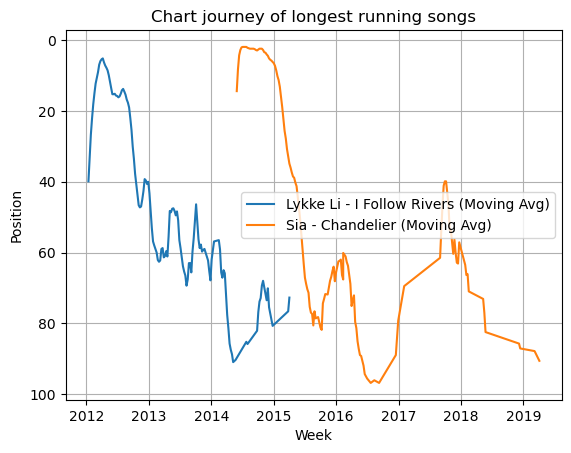

In [54]:
# Lykke Li 2011-2016
lykkeli_df = FRcharts_df[FRcharts_df['song_id'] == "i follow rivers-lykke li"]

# Sia 2014-2019
sia_df = FRcharts_df[FRcharts_df['song_id'] == "chandelier-sia"]

# Calculate the moving average
lykkeli_df['MovingAvg'] = lykkeli_df['Position'].rolling(window=8, center=True).mean()
sia_df['MovingAvg'] = sia_df['Position'].rolling(window=8, center=True).mean()

# Create a new figure and axes
fig, ax = plt.subplots()

# Plot the song's position evolution and moving average
ax.plot(lykkeli_df['chart_date'], lykkeli_df['MovingAvg'], label="Lykke Li - I Follow Rivers (Moving Avg)")
ax.plot(sia_df['chart_date'], sia_df['MovingAvg'], label="Sia - Chandelier (Moving Avg)")
#ax.scatter(lykkeli_df['chart_date'], lykkeli_df['Position'], label="Lykke Li - I Follow Rivers", color='blue', alpha=0.5)
#ax.scatter(sia_df['chart_date'], sia_df['Position'], label="Sia - Chandelier", color='orange', alpha=0.5)

# Set the labels, title and legend
ax.set_xlabel('Week')
ax.set_ylabel('Position')
ax.set_title('Chart journey of longest running songs')
ax.invert_yaxis() # position 1 should be on top
ax.legend()

# Display the plot
plt.grid(True)
plt.show()

In [55]:
sia_df


,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id,chart_date,main_artist,artist_featured,MovingAvg
118901,50,+119,Sia,Chandelier,2014,Semaine du 02 mai 2014,1419,chandelier-sia,2014-05-02,Sia,,NaN
118985,34,+16,Sia,Chandelier,2014,Semaine du 09 mai 2014,1420,chandelier-sia,2014-05-09,Sia,,NaN
119065,14,+20,Sia,Chandelier,2014,Semaine du 16 mai 2014,1421,chandelier-sia,2014-05-16,Sia,,NaN
119159,8,+6,Sia,Chandelier,2014,Semaine du 23 mai 2014,1422,chandelier-sia,2014-05-23,Sia,,NaN
119254,3,+5,Sia,Chandelier,2014,Semaine du 30 mai 2014,1423,chandelier-sia,2014-05-30,Sia,,14.375
...,...,...,...,...,...,...,...,...,...,...,...,...
143744,93,+29,Sia,Chandelier,2019,Semaine du 08 mars 2019,1911,chandelier-sia,2019-03-08,Sia,,87.875
144123,72,Entrée,Sia,Chandelier,2019,Semaine du 05 avril 2019,1915,chandelier-sia,2019-04-05,Sia,,90.625
144750,99,Entrée,Sia,Chandelier,2019,Semaine du 17 mai 2019,1921,chandelier-sia,2019-05-17,Sia,,NaN
147746,95,+8,Sia,Chandelier,2019,Semaine du 13 décembre 2019,1951,chandelier-sia,2019-12-13,Sia,,NaN


In [56]:
lykkeli_df

,Position,Position Evolution,Artist,Song Title,Year,Week,URL Week ID,song_id,chart_date,main_artist,artist_featured,MovingAvg
106525,74,Entrée,Lykke Li,I Follow Rivers,2011,Semaine du 23 décembre 2011,1152,i follow rivers-lykke li,2011-12-23,Lykke Li,,NaN
106615,64,+10,Lykke Li,I Follow Rivers,2011,Semaine du 30 décembre 2011,1153,i follow rivers-lykke li,2011-12-30,Lykke Li,,NaN
106697,46,+18,Lykke Li,I Follow Rivers,2012,Semaine du 30 décembre 2011,1201,i follow rivers-lykke li,2011-12-30,Lykke Li,,NaN
106791,40,+6,Lykke Li,I Follow Rivers,2012,Semaine du 06 janvier 2012,1202,i follow rivers-lykke li,2012-01-06,Lykke Li,,NaN
106882,31,+9,Lykke Li,I Follow Rivers,2012,Semaine du 13 janvier 2012,1203,i follow rivers-lykke li,2012-01-13,Lykke Li,,39.875
...,...,...,...,...,...,...,...,...,...,...,...,...
123615,64,+69,Lykke Li,I Follow Rivers,2015,Semaine du 27 mars 2015,1514,i follow rivers-lykke li,2015-03-27,Lykke Li,,76.625
123736,85,-21,Lykke Li,I Follow Rivers,2015,Semaine du 03 avril 2015,1515,i follow rivers-lykke li,2015-04-03,Lykke Li,,72.750
124847,96,+49,Lykke Li,I Follow Rivers,2015,Semaine du 19 juin 2015,1526,i follow rivers-lykke li,2015-06-19,Lykke Li,,NaN
128593,42,+132,Lykke Li,I Follow Rivers,2016,Semaine du 01 avril 2016,1614,i follow rivers-lykke li,2016-04-01,Lykke Li,,NaN


## Aggregating data sources

In [57]:
# Get unique artists from hot100_df and FRcharts_df
unique_artists_chartsUSFR = list(hot100_df['main_artist'].unique()) + list(hot100_df['artist_featured'].unique()) + list(FRcharts_df['main_artist'].unique()) + list(FRcharts_df['artist_featured'].unique())

# Remove duplicates, turn to string all artist names (some were previously float), sort the list
unique_artists_chartsUSFR = list(set(unique_artists_chartsUSFR))
unique_artists_chartsUSFR = [str(element) for element in unique_artists_chartsUSFR]
unique_artists_chartsUSFR = sorted(unique_artists_chartsUSFR)

print("Total unique artists:", len(unique_artists_chartsUSFR))
print(unique_artists_chartsUSFR)

# Hot 100 + Top FR = 13567 (previously 14865 before processing featured artists)

Total unique artists: 13515
['', '"Boris"', '"Groove" Holmes', '"Little" Jimmy Dickens', '"Pookie" Hudson', '"Weird Al" Yankovic', '$-Crew', '$-crew', '$NOT', "'N Sync", "'Til Tuesday", '(+44)', '(The Preacher) Bobby Womack', '-M-', '.fun', '0', '070 Shake', '1 Of The Girls', '10 Years', '10,000 Maniacs', '100 Artistes Ensemble Contre Le Sida', '100 Proof Aged in Soul', '100 Strings', '101 (One O One Electric Dream)', '10cc', '112', '113', '113, Magic System & Mohamed Lamine', '12 Gauge', '13 Block', '13 Organisé', '1789, Les Amants de la Bastille', '1910 Fruitgum Co.', '1927', '1995', '2 Be 3', '2 Chainz', '2 Chainz x Gucci Mane x Quavo', '2 Chainz, Big SeanNicki Minaj', '2 Chainz, Drake', '2 Chainz, Meek MillJeremih', '2 ChainzB.o.B', '2 ChainzBig Sean', '2 ChainzYoung Thug', '2 Eivissa', '2 Hyped Brothers', '2 In A Room', '2 Of Clubs', '2 Pac', '2 Pistols', '2 Unlimited', '2-4 Family', '20 Fingers', '20 Years After', '21 Savage', '21 Savage  Mustafa', '21 Savage  Travis Scott', '21 

In [58]:
# Find features, duos, etc.

# Define the keywords to search for
keywords = ['feat', 'feat\.', 'featuring', '&', ' and ', ' et ']

# Compile the regular expression pattern
pattern = re.compile(r'|'.join(keywords), re.IGNORECASE)

# Find artists that match the pattern
matched_artists = [artist for artist in unique_artists if re.search(pattern, artist)]

# Print the matched artists and the count
for artist in matched_artists:
    print(artist)

print("Total matched artists:", len(matched_artists))

#4997 artists with potential features, duos, etc in Billboard & Top 50 charts.
# (some are actual band names, so we can't strip the features all at once.
# Let's try to get info for all artists from Musicbrainz and deal after with those
# that remain unmatched)

# 5396 after adding Last.fm

NameError: name 'unique_artists' is not defined

In [59]:
# Find featuring to keep only main artist (or split to keep the featured?)

# Define the keywords to search for
keywords = ['feat', 'feat\.', 'featuring']

# Compile the regular expression pattern
pattern = re.compile(r'|'.join(keywords), re.IGNORECASE)

# Find artists that match the pattern
matched_artists = [artist for artist in unique_artists_chartsUSFR if re.search(pattern, artist)]

# Print the matched artists and the count
for artist in matched_artists:
    print(artist)

print("Total matched artists:", len(matched_artists))

#3091 artists with features in Billboard & Top 50 charts.


Feather
Total matched artists: 1


In [57]:
# Define the keywords to search for
keywords = ['feat', 'feat\.', 'featuring']

# Compile the regular expression pattern
pattern = re.compile(r'|'.join(keywords), re.IGNORECASE)
parentheses_pattern_main = re.compile(r'\s*\($')
brackets_pattern_main = re.compile(r'\s*\[$')
parentheses_pattern_featured = re.compile(r'([^()\[\]]+)\s*[)\]]+$')

# Method 1: Keep only the main artist
cleaned_artists_main = []
featured_artists = []
for artist in unique_artists_chartsUSFR:
    match = re.search(pattern, artist)
    if match:
        cleaned_artist = artist[:match.start()].strip()
        cleaned_artist = re.sub(parentheses_pattern_main, '', cleaned_artist).strip()
        cleaned_artist = re.sub(brackets_pattern_main, '', cleaned_artist).strip()
        cleaned_artists_main.append(cleaned_artist)
    else:
        cleaned_artists_main.append(artist)

# Method 2: Keep the featured artists
cleaned_artists_featured = []
for artist in unique_artists_chartsUSFR:
    match = re.search(pattern, artist)
    if match:
        featured_artist = re.sub(pattern, '', artist[match.end():]).strip('. ').lstrip('uring ')
        cleaned_artists_featured.append(featured_artist)


# Print the results
print("Method 1: Keep only the main artist")
print("-----")
for artist in cleaned_artists_main:
    print(artist)

print("-------------------------------------")
print("\nMethod 2: Keep the featured artists")
for artist in cleaned_artists_featured:
    print(artist)

print("-------------------------------------")
print("\nTotal unique artists:", len(unique_artists_chartsUSFR))
print("Total cleaned artists (Method 1):", len(cleaned_artists_main))
print("Total featured artists (Method 2):", len(cleaned_artists_featured))

#Total matched artists: 14865
#Total cleaned artists (Method 1): 14865
#Total featured artists (Method 2): 3091

Method 1: Keep only the main artist
-----

"Boris"
"Groove" Holmes
"Little" Jimmy Dickens
"Pookie" Hudson
"Weird Al" Yankovic
$-Crew
$-crew
$NOT & A$AP Rocky
'N Sync
'N Sync & Gloria Estefan
'Til Tuesday
(+44)
(The Preacher) Bobby Womack
-M-
.fun
0
070 Shake
1 Of The Girls
10 Years
10,000 Maniacs
100 Artistes Ensemble Contre Le Sida
100 Proof Aged in Soul
100 Strings and Jono (Choir of 40 Voices)
101 (One O One Electric Dream)
10cc
112
113
113, Magic System & Mohamed Lamine
12 Gauge
13 Block
13 Organisé
1789, Les Amants de la Bastille
1910 Fruitgum Co.
1927
1995
2 Be 3
2 Chainz
2 Chainz & B.o.B
2 Chainz & Big Sean
2 Chainz & Wiz Khalifa
2 Chainz & Young Thug
2 Chainz x Gucci Mane x Quavo
2 Chainz, Big Sean & Nicki Minaj
2 Chainz, Drake & Quavo
2 Chainz, Meek Mill & Jeremih
2 Eivissa
2 Hyped Brothers & A Dog
2 In A Room
2 Of Clubs
2 Pac
2 Pistols
2 Unlimited
2-4 Family
20 Fingers
20 Years After
21 Savage
21 Savage & 42 Dugg
21 Savage & Baby Tate
21 Savage & Metro Boomin
21 Savage & Proj

In [58]:
# Previous ERRORS
# Check that they have been cleaned
# "BLACKstreet (" or "Babyface (", "Changing Faces (", "Das EFX (", "Dis L'Heure 2 Zouk (Lynnsha - Sweety", "Do Or Die (, "E-40 (" 4353 empty, Giorgio Moroder (, Glenn Medeiros (, Immature (, Jesse Johnson (, Keith Sweat (, L.F.O. (Lyte Funky Ones) (, Linda Ronstadt (, Ol Skool [, Or-N-More (, Patrick Swayze (, Puff Daddy & The Family (, Puff Daddy (, Quincy Jones (, R. Kelly Or Bow Wow (, SWV (, Seals & Crofts (, Shabba Ranks (, Shaggy (, Soul II Soul (, Stacy Earl (, Subway (, The Cantina Band (, The Lox [, The Miracles (, The Ovations (, The Poppy Family (, Veronica (

## Create Artist table, get Gender & other info from Musicbrainz API

### Fetch Artist info (type, gender, mbid, area, begin/end dates, tags (incl. genres))

In [60]:
# Set up the Musicbrainz API from .env

musicbrainz_app = os.environ['musicbrainz_app']
musicbrainz_ver = os.environ['musicbrainz_ver']
musicbrainz_mail = os.environ['musicbrainz_mail']

musicbrainzngs.set_useragent(musicbrainz_app, musicbrainz_ver, musicbrainz_mail)

In [61]:
def fetch_artist_info(artist):
    result = musicbrainzngs.search_artists(artist=artist, limit=1)

    if 'artist-list' in result:
        artists = result['artist-list']
        if artists:
            artist_info = artists[0]
            artist_name = artist_info['name']

            # Get the artist's MusicBrainz ID
            mbid = artist_info['id']

            # Retrieve additional information using the MusicBrainz ID
            artist_details = musicbrainzngs.get_artist_by_id(mbid, includes=['tags', 'release-groups'])

            # Get the artist's type, gender, area, begin and end dates
            artist_type = artist_details['artist'].get('type')
            artist_gender = artist_details['artist'].get('gender')
            artist_area = artist_details['artist'].get('area', {}).get('name')

            # Get the artist's genres tags (with counts)
            genre_tags = []
            if 'tag-list' in artist_details['artist']:
                tags = artist_details['artist']['tag-list']
                for tag in tags:
                    tag_name = tag['name']
                    genre_tags.append(tag_name)
                    
            #if 'genre-list' in artist_details['artist']:
            #genres = artist_details['artist']['genre-list']
            #for genre in genres:
            #    tag = genre['name']
            #    count = genre['count']
            #    genre_tags.append({'tag': tag, 'count': count})

            #genres = artist_details['artist'].get('tag-list', [])
            #artist_genres = [(genre['name'], genre['count']) for genre in genres]

            # Get the artist's other tags (with counts)
            other_tags = []
            if 'user-tag-list' in artist_details['artist']:
                tags = artist_details['artist']['user-tag-list']
                for tag in tags:
                    tag_name = tag['name']
                    other_tags.append(tag_name)
                    #tag_count = tag['count']
                    #other_tags.append({'tag': tag_name, 'count': tag_count})

            # Get the artist's begin and end dates if available
            if 'life-span' in artist_details['artist']:
                artist_life_span = artist_details['artist']['life-span']
                artist_begin_date = artist_life_span.get('begin')
                artist_end_date = artist_life_span.get('end')
            else:
                artist_begin_date = None
                artist_end_date = None
                
            # Create a dictionary with the artist information
            artist_info_dict = {
                'Artist': artist_name,
                'MusicBrainz ID': mbid,
                'Type': artist_type,
                'Gender': artist_gender,
                'Area': artist_area,
                'Begin Date': artist_begin_date,
                'End Date': artist_end_date,
                'Genres': genre_tags,
                'Other Tags': other_tags
            }

            return artist_info_dict

    return None

In [62]:
# MUSIC BRAINZ API REQUESTS

###########################

# # Create an empty list to store the artist information
# artist_info_list = []
# 
# artist_test # OK (57 sec for 29 artists)
# batch1 = unique_artists_chartsUSFR[:100] #estim 3'17 OK
# batch2 = unique_artists_chartsUSFR[100:8000] #estim 4h18 OK ! export OK in expected time though VS code did seem to have crashed.
# batch3 = unique_artists_chartsUSFR[8000:9000] #estim ca. 33' export OK up to Patrick F
# batch4 = unique_artists_chartsUSFR[9000:9300] # estim ca. 10' export OK up to Point Blank
# batch5 = unique_artists_chartsUSFR[9300:9800] # larger batch crashed during lunch time / back to smaller batches export OK up to Ricoune
# batch6 = unique_artists_chartsUSFR[9800:10800] # export OK up to Slender
# batch7 = unique_artists_chartsUSFR[10800:11500] # export OK up to the Cardigans (23')
# batch8 = unique_artists_chartsUSFR[11500:12200] # export OK up to The Rubettes (23')
# batch9 = unique_artists_chartsUSFR[12200:12900] # export OK up to U2 (23')
# batch10 = unique_artists_chartsUSFR[12900:] # export OK! total len(unique_artists_chartsUSFR) = 13567
# 
# for artist in batch10:  
#     try:
#         artist_info_dict = fetch_artist_info(artist)
#         if artist_info_dict:
#             artist_info_list.append(artist_info_dict)
#             print(f"Scraped: {artist}")
#     except Exception as e:
#         print(f"ERROR scraping artist: {artist}. {str(e)}")
# 
# # Create a DataFrame from the artist information list
# artist_info_df = pd.DataFrame(artist_info_list)
# artist_info_df.to_csv('artist_info.csv', mode='a', header=not os.path.isfile('artist_info.csv'))
# 
# artist_info_df

### Importing previously scraped artist_info.csv

In [319]:
artist_info_df = pd.read_csv('artist_info.csv', sep=',', index_col=0)

In [101]:
artist_info_df.shape
#13495 rows

(13495, 9)

### Remove duplicates (from 13495 to 10754 artists)

In [320]:
#Remove duplicates
artist_info_df = artist_info_df.drop_duplicates(subset='MusicBrainz ID')
artist_info_df.shape
#now 10754 rows

(10754, 9)

### Import Genre list and sort Tags (Genre_tags / Other_tags)

In [321]:
#Import CSV list of Genres, scraped from MusicBrainz
genres_df = pd.read_csv('musicbrainz_genres.csv', sep=',', index_col=None)
genres_df

,Genres
0,2 tone
1,2-step
2,aak
3,abhang
4,aboio
...,...
1769,zolo
1770,zouglou
1771,zouk
1772,zouk love


In [322]:
artist_info_df = artist_info_df.rename(columns={'Genres': 'Tags'})
artist_info_df

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,Tags,Other Tags
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992,NaN,"['ambient', 'dissonant', 'doom metal', 'drone'...",[]
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"['hard bop', 'jazz and blues', 'soul jazz']",[]
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,[],[]
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,[],[]
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaN,"['accordion', 'american', 'comedy', 'comedy ro...",[]
...,...,...,...,...,...,...,...,...,...
655,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaN,NaN,[],[]
656,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992,NaN,['hip hop'],[]
657,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992,NaN,[],[]
660,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaN,"['arranger', 'arrangeur', 'composer', 'composi...",[]


In [323]:
artist_info_df = artist_info_df.rename(columns={'Other Tags': 'Genres'})


In [324]:
artist_info_df['Genres'].value_counts()

[]    10754
Name: Genres, dtype: int64

In [325]:
#Let's drop that empty Genre column

artist_info_df.drop('Genres', axis=1, inplace=True)
artist_info_df

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,Tags
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992,NaN,"['ambient', 'dissonant', 'doom metal', 'drone'..."
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"['hard bop', 'jazz and blues', 'soul jazz']"
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,[]
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,[]
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaN,"['accordion', 'american', 'comedy', 'comedy ro..."
...,...,...,...,...,...,...,...,...
655,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaN,NaN,[]
656,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992,NaN,['hip hop']
657,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992,NaN,[]
660,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaN,"['arranger', 'arrangeur', 'composer', 'composi..."


In [326]:
# Initialize dictionaries
genretag_dict = {}
othertag_dict = {}

# Populate dictionaries with tags
for index, row in artist_info_df.iterrows():
    mbid = row['MusicBrainz ID']
    tags = row['Tags']
    tags = ast.literal_eval(row['Tags'])  # Convert string to list (our tag list previously seem to have been a string rather than an actual list!)
    genre_tags = [tag for tag in tags if tag in genres_df['Genres'].tolist()]
    other_tags = [tag for tag in tags if tag not in genre_tags]
    genretag_dict[mbid] = genre_tags
    othertag_dict[mbid] = other_tags

# Print dictionaries
print("genretag_dict:", genretag_dict)
print("othertag_dict:", othertag_dict)

genretag_dict: {'57652bf8-cfe8-42e7-b9a7-5572a7080d8d': ['ambient', 'doom metal', 'drone', 'drone metal', 'experimental', 'noise', 'noise rock', 'post-metal', 'psychedelic rock', 'shoegaze', 'sludge metal', 'stoner metal'], '726cfe69-c905-4161-a10c-accb13d9ec26': ['hard bop', 'soul jazz'], 'bd7589a3-f82f-4c3d-b7e2-e57e89552da1': [], '29dc9009-015f-47c4-bd17-ed2af6d2ae0c': [], '7746d775-9550-4360-b8d5-c37bd448ce01': ['comedy', 'comedy rock', 'polka', 'pop', 'rock'], 'af3d3c30-fcd5-4012-91a2-7a2845827ccc': [], '25b7b584-d952-4662-a8b9-dd8cdfbfeb64': ['east coast hip hop', 'hip hop'], 'ea2603e5-7412-49d9-80bc-60cc3c02cd87': [], 'becd8cc6-a453-4183-af88-dedaaec859a6': ['dance', 'dance-pop', 'latin', 'latin pop', 'pop', 'pop rock', 'rock', 'son cubano'], '8cf8869d-e066-4c94-b734-fe05749badf0': ['alternative rock', 'new wave'], 'c2a44e93-3a2b-44aa-bd8b-7a71bb76e3b5': ['pop punk'], '48e78462-2f0b-4a1a-9fa4-0585e2991e80': ['funk', 'r&b', 'soul', 'southern soul'], '5403bf6e-bc1d-4e62-b31f-926a2

In [327]:
# Check number of keys in dictionaries:

print('Genres: ',len(genretag_dict))
print('Other: ',len(othertag_dict))
num_unique_ids = artist_info_df['MusicBrainz ID'].nunique()
print("unique MusicBrainz IDs:", num_unique_ids)

# Confirm that all have the same length, so we can map


Genres:  10754
Other:  10754
unique MusicBrainz IDs: 10754


In [328]:
#Map to populate the new genres / other tags columns
artist_info_df['genre_tags'] = artist_info_df['MusicBrainz ID'].map(genretag_dict)
artist_info_df['other_tags'] = artist_info_df['MusicBrainz ID'].map(othertag_dict)

#Drop previous Tags column
artist_info_df.drop('Tags', axis=1, inplace=True)
artist_info_df

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992,NaN,"[ambient, doom metal, drone, drone metal, expe...","[dissonant, english, japan, japanese, raw, rep..."
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"[hard bop, soul jazz]",[jazz and blues]
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,[],[]
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,[],[]
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaN,"[comedy, comedy rock, polka, pop, rock]","[accordion, american, parody, pizza, ponycore,..."
...,...,...,...,...,...,...,...,...,...
655,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaN,NaN,[],[]
656,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992,NaN,[hip hop],[]
657,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992,NaN,[],[]
660,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaN,"[electronica, pop, trip hop]","[arranger, arrangeur, composer, compositeur, f..."


#### Convert Date columns to dates (currently year or date)

In [330]:
# Convert 'Begin Date' and 'End Date' to datetime, handling errors
artist_info_df['Begin Date'] = pd.to_datetime(artist_info_df['Begin Date'], errors='coerce')
artist_info_df['End Date'] = pd.to_datetime(artist_info_df['End Date'], errors='coerce')


# Display the updated DataFrame
artist_info_df

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992-01-01,NaT,"[ambient, doom metal, drone, drone metal, expe...","[dissonant, english, japan, japanese, raw, rep..."
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"[hard bop, soul jazz]",[jazz and blues]
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,NaN,NaN
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,NaN,NaN
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaT,"[comedy, comedy rock, polka, pop, rock]","[accordion, american, parody, pizza, ponycore,..."
...,...,...,...,...,...,...,...,...,...
655,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaT,NaT,NaN,NaN
656,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992-01-01,NaT,[hip hop],NaN
657,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992-01-01,NaT,NaN,NaN
660,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaT,"[electronica, pop, trip hop]","[arranger, arrangeur, composer, compositeur, f..."


#### Clean Tags

In [332]:
artist_info_df['other_tags'].value_counts().head(50)

[2008 universal fire victim]                          237
[classic pop and rock]                                140
[french]                                               87
[american]                                             70
[rock and indie]                                       60
[pop and chart]                                        40
[hip hop rnb and dance hall]                           40
[synthpop]                                             33
[english]                                              33
[british, english, uk]                                 32
[singer/songwriter]                                    28
[american idol]                                        27
[british]                                              26
[latin urban]                                          26
[rap]                                                  26
[2008 universal fire victim, classic pop and rock]     25
[adult contemporary]                                   23
[rhythm & blue

In [333]:
# Remove '2008 universal fire victim' that does not indicate artist similarity and could influence our future machine learning.

artist_info_df['other_tags'] = artist_info_df['other_tags'].apply(lambda x: [tag for tag in x if tag != '2008 universal fire victim'] if isinstance(x, list) else x)


In [334]:
artist_info_df['other_tags'].value_counts().head(50)

[]                                              237
[classic pop and rock]                          165
[french]                                         87
[american]                                       83
[rock and indie]                                 61
[hip hop rnb and dance hall]                     42
[pop and chart]                                  40
[synthpop]                                       34
[british, english, uk]                           34
[english]                                        34
[singer/songwriter]                              32
[adult contemporary]                             32
[american idol]                                  27
[british]                                        27
[latin urban]                                    26
[rhythm and blues]                               26
[rhythm & blues]                                 26
[rap]                                            26
[rock & roll]                                    19
[dance and e

In [335]:
# Replace empty lists with NaN in 'genre_tags' column
artist_info_df['genre_tags'] = artist_info_df['genre_tags'].apply(lambda x: np.nan if x == [] else x)

# Replace empty lists with NaN in 'other_tags' column
artist_info_df['other_tags'] = artist_info_df['other_tags'].apply(lambda x: np.nan if x == [] else x)

artist_info_df

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992-01-01,NaT,"[ambient, doom metal, drone, drone metal, expe...","[dissonant, english, japan, japanese, raw, rep..."
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"[hard bop, soul jazz]",[jazz and blues]
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,NaN,NaN
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,NaN,NaN
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaT,"[comedy, comedy rock, polka, pop, rock]","[accordion, american, parody, pizza, ponycore,..."
...,...,...,...,...,...,...,...,...,...
655,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaT,NaT,NaN,NaN
656,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992-01-01,NaT,[hip hop],NaN
657,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992-01-01,NaT,NaN,NaN
660,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaT,"[electronica, pop, trip hop]","[arranger, arrangeur, composer, compositeur, f..."


In [336]:
artist_info_df['other_tags'].value_counts().head(50)

[classic pop and rock]                          165
[french]                                         87
[american]                                       83
[rock and indie]                                 61
[hip hop rnb and dance hall]                     42
[pop and chart]                                  40
[synthpop]                                       34
[english]                                        34
[british, english, uk]                           34
[adult contemporary]                             32
[singer/songwriter]                              32
[british]                                        27
[american idol]                                  27
[latin urban]                                    26
[rap]                                            26
[rhythm and blues]                               26
[rhythm & blues]                                 26
[rock & roll]                                    19
[dance and electronica]                          18
[british, cl

## Fetch Artist Bio from Last.FM API

In [73]:
# Set up API key from .env

last_api_key = os.environ['last_api_key']

In [ ]:
# Fetch artist bios from Last.fm, using their musicbrainz ID (mbid)

# artist_bios = []  # List to store the retrieved artist bios
# 
# 
# for index, mbid in enumerate(list_artist_mbids[0:10]):
#     try:
#         artist = artist_info_df.loc[index, 'Artist']
#         
#         # Send a request to the Last.fm API to retrieve the artist's bio
#         url = f'http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&mbid={mbid}&api_key={last_api_key}&format=json'
#         response = requests.get(url)
#         data = json.loads(response.text)
#         
#         if 'artist' in data:
#             artist_bio = data['artist']['bio']['content']
#             artist_bios.append({'Artist': artist, 'MBID': mbid, 'Bio': artist_bio})
#         else:
#             artist_bios.append({'Artist': artist, 'MBID': mbid, 'Bio': None})  # Append None if artist not found or bio not available
#     
#         print(f"Scraped bio for artist {index+1}/{len(list_artist_mbids[0:10])}")
#     
#     except Exception as e:
#         print(f"Error retrieving bio for artist {artist} (MBID: {mbid}): {str(e)}")
#         artist_bios.append({'Artist': artist, 'MBID': mbid, 'Bio': None})  # Append None in case of any error
# 
# # Create a new DataFrame from the artist_bios list
# artist_bios_df = pd.DataFrame(artist_bios)
# 
# # Export the DataFrame to a JSON file
# artist_bios_df.to_json('artist_bios.json', orient='records')

# Export the Dataframe to a CSV file
# artist_bios_df.to_csv('artist_bios.csv', index=False)

### Import previously fetched bios

In [141]:
artist_bios_df = pd.read_csv('artist_bios.csv', sep=',', index_col=0)

In [112]:
artist_bios_df

,Bio
MBID,
57652bf8-cfe8-42e7-b9a7-5572a7080d8d,There are at least two different artists using...
726cfe69-c905-4161-a10c-accb13d9ec26,"Richard Arnold ""Groove"" Holmes, Born Richard A..."
bd7589a3-f82f-4c3d-b7e2-e57e89552da1,"James Cecil Dickens (born December 19, 1920 - ..."
29dc9009-015f-47c4-bd17-ed2af6d2ae0c,"Thornton James (""Pookie"") Hudson ( born Des Mo..."
7746d775-9550-4360-b8d5-c37bd448ce01,"Alfred Matthew ""Weird Al"" Yankovic (born Octob..."
...,...
8cda32b5-1447-4ded-8a0e-f1cf8e6b3480,Élodie Frégé won France's Star Academy in 200...
01252145-c9e8-4de5-a480-9b2bed05450a,Émilie Simon is a French singer and composer b...
1e0de31c-4957-4649-9aa3-7b0f1d9d2c84,"Étienne Daho (born January 14, 1956 in Oran, A..."


### Remove duplicates (from 13495 artists to 10754)

In [142]:
artist_bios_df = artist_bios_df.reset_index().drop_duplicates(subset=['MBID']).set_index('MBID')
artist_bios_df

,Bio
MBID,
57652bf8-cfe8-42e7-b9a7-5572a7080d8d,There are at least two different artists using...
726cfe69-c905-4161-a10c-accb13d9ec26,"Richard Arnold ""Groove"" Holmes, Born Richard A..."
bd7589a3-f82f-4c3d-b7e2-e57e89552da1,"James Cecil Dickens (born December 19, 1920 - ..."
29dc9009-015f-47c4-bd17-ed2af6d2ae0c,"Thornton James (""Pookie"") Hudson ( born Des Mo..."
7746d775-9550-4360-b8d5-c37bd448ce01,"Alfred Matthew ""Weird Al"" Yankovic (born Octob..."
...,...
46acab74-83fe-4d7a-90cd-fca626f229fb,NaN
201ac6bb-c268-4e9d-9390-5305512d5ee2,"Ärsenik is a french rap duo, founded in 1997, ..."
04611209-2171-4652-98cd-e2c5e536ac04,É o Tchan! (not to be confused with the ghetto...


In [114]:
artist_bios_df.columns

Index(['Bio'], dtype='object')

## Merging all Artist info

In [298]:
artist_info_df

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992,NaN,"[ambient, doom metal, drone, drone metal, expe...","[dissonant, english, japan, japanese, raw, rep..."
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"[hard bop, soul jazz]",[jazz and blues]
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,[],[]
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,[],[]
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaN,"[comedy, comedy rock, polka, pop, rock]","[accordion, american, parody, pizza, ponycore,..."
...,...,...,...,...,...,...,...,...,...
655,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaN,NaN,[],[]
656,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992,NaN,[hip hop],[]
657,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992,NaN,[],[]
660,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaN,"[electronica, pop, trip hop]","[arranger, arrangeur, composer, compositeur, f..."


In [337]:
artist_info_with_bio = pd.merge(artist_info_df, artist_bios_df, how='left', left_on="MusicBrainz ID", right_on="MBID")
artist_info_with_bio

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags,Bio
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992-01-01,NaT,"[ambient, doom metal, drone, drone metal, expe...","[dissonant, english, japan, japanese, raw, rep...",There are at least two different artists using...
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"[hard bop, soul jazz]",[jazz and blues],"Richard Arnold ""Groove"" Holmes, Born Richard A..."
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,NaN,NaN,"James Cecil Dickens (born December 19, 1920 - ..."
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,NaN,NaN,"Thornton James (""Pookie"") Hudson ( born Des Mo..."
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaT,"[comedy, comedy rock, polka, pop, rock]","[accordion, american, parody, pizza, ponycore,...","Alfred Matthew ""Weird Al"" Yankovic (born Octob..."
...,...,...,...,...,...,...,...,...,...,...
10749,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaT,NaT,NaN,NaN,NaN
10750,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992-01-01,NaT,[hip hop],NaN,"Ärsenik is a french rap duo, founded in 1997, ..."
10751,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992-01-01,NaT,NaN,NaN,É o Tchan! (not to be confused with the ghetto...
10752,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaT,"[electronica, pop, trip hop]","[arranger, arrangeur, composer, compositeur, f...",Émilie Simon is a French singer and composer b...


### Data Cleaning

In [302]:
artist_info_with_bio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10754 entries, 0 to 10753
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Artist          10754 non-null  object        
 1   MusicBrainz ID  10754 non-null  object        
 2   Type            10113 non-null  object        
 3   Gender          5595 non-null   object        
 4   Area            9127 non-null   object        
 5   Begin Date      7971 non-null   datetime64[ns]
 6   End Date        2258 non-null   datetime64[ns]
 7   genre_tags      5315 non-null   object        
 8   other_tags      3424 non-null   object        
 9   Bio             7839 non-null   object        
dtypes: datetime64[ns](2), object(8)
memory usage: 924.2+ KB


In [303]:
artist_info_with_bio.describe()

/var/folders/xd/d3dyqcnj5nq2br9rb4b8gqx80000gn/T/ipykernel_20377/2772965552.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  artist_info_with_bio.describe()
/var/folders/xd/d3dyqcnj5nq2br9rb4b8gqx80000gn/T/ipykernel_20377/2772965552.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  artist_info_with_bio.describe()


,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags,Bio
count,10754,10754,10113,5595,9127,7971,2258,5315,3424,7839
unique,10753,10754,6,5,301,4575,1215,2901,1814,7809
top,LFO,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Person,Male,United States,1969-01-01 00:00:00,1969-01-01 00:00:00,[hip hop],[2008 universal fire victim],"Stevland Hardaway Morris (né Judkins; May 13, ..."
freq,2,1,5808,3854,4800,83,35,370,237,2
first,NaN,NaN,NaN,NaN,NaN,1683-09-25 00:00:00,1704-02-24 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2022-06-08 00:00:00,2023-05-25 00:00:00,NaN,NaN,NaN


#### Drop anonymous and homonymous artists

In [338]:
mask = (artist_info_with_bio['Artist'] == '[no artist]') | (artist_info_with_bio['Artist'] == '[anonymous]')
artists_to_drop = artist_info_with_bio[mask]
artists_to_drop

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags,Bio
6760,[no artist],eec63d3c-3b81-4ad4-b1e4-7c147d4d2b61,Other,Not applicable,NaN,NaT,NaT,NaN,"[do not merge, meta artist, special purpose, s...",This is probably mistagged for Wolfgang Amadeu...
8961,[anonymous],f731ccc4-e22a-43af-a747-64213329e088,Other,Not applicable,[Worldwide],NaT,NaT,NaN,"[anon, anonymous, special purpose, special pur...",Gregorian is a German band headed by Frank Pet...


In [339]:
artist_info_with_bio.drop(artists_to_drop.index, inplace=True)

In [340]:
#Check that anonymous artists have been dropped
remaining_rows = artist_info_with_bio[artist_info_with_bio['Artist'].isin(['[no artist]','[anonymous]'])]
remaining_rows

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags,Bio


In [341]:
#Check homonymous artists
artist_info_with_bio['Artist'].value_counts() == 2

LFO                 True
Parcels            False
Paperboy           False
Papi Sánchez       False
Papoose            False
                   ...  
Power Funk         False
Funkadelic         False
Funkdoobiest       False
Funkmaster Flex    False
Ólafur Arnalds     False
Name: Artist, Length: 10751, dtype: bool

In [342]:
# Check the 2 LFO artists
lfo_artist = artist_info_with_bio.loc[artist_info_with_bio['Artist'] == 'LFO']
lfo_artist

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags,Bio
5396,LFO,56df5343-86ac-4dd9-8331-173a4439337e,Group,NaN,United States,1995-01-01,2018-11-21,"[hip hop, pop, pop rap, teen pop]",[boy band],There are 2 bands under the name LFO:\n1. An E...
5402,LFO,e6d0179f-b899-4563-b6c6-88715aaae0b8,Group,NaN,United Kingdom,1988-01-01,2014-10-12,"[bleep techno, electronic, electronica, idm, t...","[british, dance and electronica, english, uk, ...",There are 2 bands under the name LFO:\n1. An E...


In [343]:
#Check LFO data in original Hot100 charts
lfo_songs = hot100_df.loc[hot100_df['performer'] == 'LFO', ['song_id', 'chart_debut']].groupby(['song_id', 'chart_debut']).size().reset_index(name='count')
lfo_songs

,song_id,chart_debut,count
0,every other time-lfo,2001-08-25,18
1,girl on tv-lfo,1999-11-20,17
2,i don't wanna kiss you goodnight-lfo,2000-04-15,5
3,summer girls-lfo,1999-07-17,17
4,west side story-lfo,2000-08-05,4


In [344]:
#Drop homonymous LFO from the UK (the one in the charts -unfortunately- is a US boy band)
artist_info_with_bio = artist_info_with_bio.loc[~((artist_info_with_bio['Artist'] == 'LFO') & (artist_info_with_bio['Area'] == 'United Kingdom'))]


In [345]:
#CHeck that UK LFO has been dropped
lfo_artist = artist_info_with_bio.loc[artist_info_with_bio['Artist'] == 'LFO']
lfo_artist

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags,Bio
5396,LFO,56df5343-86ac-4dd9-8331-173a4439337e,Group,NaN,United States,1995-01-01,2018-11-21,"[hip hop, pop, pop rap, teen pop]",[boy band],There are 2 bands under the name LFO:\n1. An E...


In [346]:
artist_info_with_bio.columns

Index(['Artist', 'MusicBrainz ID', 'Type', 'Gender', 'Area', 'Begin Date',
       'End Date', 'genre_tags', 'other_tags', 'Bio'],
      dtype='object')

In [347]:
artist_info_with_bio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10751 entries, 0 to 10753
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Artist          10751 non-null  object        
 1   MusicBrainz ID  10751 non-null  object        
 2   Type            10110 non-null  object        
 3   Gender          5593 non-null   object        
 4   Area            9125 non-null   object        
 5   Begin Date      7970 non-null   datetime64[ns]
 6   End Date        2257 non-null   datetime64[ns]
 7   genre_tags      5314 non-null   object        
 8   other_tags      3184 non-null   object        
 9   Bio             7836 non-null   object        
dtypes: datetime64[ns](2), object(8)
memory usage: 923.9+ KB


In [348]:
gender_counts = artist_info_with_bio['Gender'].value_counts()
print(gender_counts)

Male              3854
Female            1727
Non-binary           7
Other                3
Not applicable       2
Name: Gender, dtype: int64


In [349]:
nan_bio_counts = artist_info_with_bio[artist_info_with_bio['Gender'].isin(['Male', 'Female', 'Non-binary'])]['Bio'].isna().sum()
print(nan_bio_counts)

1342


In [350]:
female_nan_bio_count = artist_info_with_bio.loc[artist_info_with_bio['Gender'] == 'Female', 'Bio'].isna().sum()
print(female_nan_bio_count)

388


In [351]:
artist_info_with_bio

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags,Bio
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992-01-01,NaT,"[ambient, doom metal, drone, drone metal, expe...","[dissonant, english, japan, japanese, raw, rep...",There are at least two different artists using...
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"[hard bop, soul jazz]",[jazz and blues],"Richard Arnold ""Groove"" Holmes, Born Richard A..."
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,NaN,NaN,"James Cecil Dickens (born December 19, 1920 - ..."
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,NaN,NaN,"Thornton James (""Pookie"") Hudson ( born Des Mo..."
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaT,"[comedy, comedy rock, polka, pop, rock]","[accordion, american, parody, pizza, ponycore,...","Alfred Matthew ""Weird Al"" Yankovic (born Octob..."
...,...,...,...,...,...,...,...,...,...,...
10749,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaT,NaT,NaN,NaN,NaN
10750,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992-01-01,NaT,[hip hop],NaN,"Ärsenik is a french rap duo, founded in 1997, ..."
10751,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992-01-01,NaT,NaN,NaN,É o Tchan! (not to be confused with the ghetto...
10752,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaT,"[electronica, pop, trip hop]","[arranger, arrangeur, composer, compositeur, f...",Émilie Simon is a French singer and composer b...


In [80]:
#Export to CSV

# artist_info_with_bio.to_csv('artist_info_with_bio.csv', index=False)

## Merging Songs and artist info

In [91]:
hot100_df.shape

(336295, 15)

In [92]:
artist_info_df.shape

(10754, 9)

In [352]:
hot100_with_artist_info = pd.merge(hot100_df, artist_info_with_bio, how='left', left_on="main_artist", right_on="Artist")
hot100_with_artist_info

,chart_position,chart_date,song,performer,instance,time_on_chart,consecutive_weeks,previous_week,peak_position,worst_position,...,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags,Bio
0,84,1990-05-05,"""B"" Girls",Young And Restless,1,1,NaN,NaN,84,84,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
1,78,1990-05-12,"""B"" Girls",Young And Restless,1,2,1.0,84.0,78,84,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
2,68,1990-05-19,"""B"" Girls",Young And Restless,1,3,2.0,78.0,68,84,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
3,60,1990-05-26,"""B"" Girls",Young And Restless,1,4,3.0,68.0,60,84,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
4,58,1990-06-02,"""B"" Girls",Young And Restless,1,5,4.0,60.0,58,84,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336290,99,2001-02-10,www.memory,Alan Jackson,1,15,14.0,89.0,45,99,...,Alan Jackson,7291957b-c463-4275-a41c-a104c9e2337f,Person,Male,United States,1958-10-17,NaT,"[bluegrass, christmas music, contemporary coun...",NaN,"Alan Eugene Jackson (born October 17, 1958) is..."
336291,66,1958-12-13,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1,1,NaN,NaN,66,66,...,Augie Rios,03a62df3-6ca1-4edc-9daa-cf6cae086f3c,NaN,NaN,NaN,NaT,NaT,NaN,NaN,"Augie Rios had the hit song ""¿Dónde Está Santa..."
336292,53,1958-12-20,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1,2,1.0,66.0,53,66,...,Augie Rios,03a62df3-6ca1-4edc-9daa-cf6cae086f3c,NaN,NaN,NaN,NaT,NaT,NaN,NaN,"Augie Rios had the hit song ""¿Dónde Está Santa..."
336293,47,1958-12-27,¿Dònde Està Santa Claus? (Where Is Santa Claus?),Augie Rios,1,3,2.0,53.0,47,66,...,Augie Rios,03a62df3-6ca1-4edc-9daa-cf6cae086f3c,NaN,NaN,NaN,NaT,NaT,NaN,NaN,"Augie Rios had the hit song ""¿Dónde Está Santa..."


In [353]:
hot100_with_artist_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336295 entries, 0 to 336294
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   chart_position     336295 non-null  int64         
 1   chart_date         336295 non-null  object        
 2   song               336295 non-null  object        
 3   performer          336295 non-null  object        
 4   instance           336295 non-null  int64         
 5   time_on_chart      336295 non-null  int64         
 6   consecutive_weeks  302987 non-null  float64       
 7   previous_week      302987 non-null  float64       
 8   peak_position      336295 non-null  int64         
 9   worst_position     336295 non-null  int64         
 10  chart_debut        336295 non-null  object        
 11  chart_url          336295 non-null  object        
 12  song_id            336295 non-null  object        
 13  main_artist        336295 non-null  object  

In [354]:
hot100_with_artist_info['Type'].value_counts()
# 188K rows for persons

Person       188018
Group         91953
Character       117
Other            82
Orchestra        37
Choir            31
Name: Type, dtype: int64

In [355]:
hot100_with_artist_info['Gender'].value_counts()
# 187K rows have gender


Male          130345
Female         55781
Non-binary      1109
Name: Gender, dtype: int64

In [ ]:
# We are missing artist info for ca. 64K rows, i.e. 19% of our dataset.
# Cleaning the artist further might allow for more songs to be matched to their artist.

In [356]:
hot100_with_artist_info['main_artist'].value_counts()

Drake                 1676
Taylor Swift          1300
Elton John            1003
Elvis Presley          995
Rihanna                925
                      ... 
RiceGum                  1
ROCKMAFIA                1
The Postal Service       1
Meghan Linsey            1
Larray                   1
Name: main_artist, Length: 7550, dtype: int64

In [357]:
nan_rows = hot100_with_artist_info[hot100_with_artist_info['main_artist'].isnull()]
columns_to_display = ['performer', 'main_artist', 'artist_featured', 'Artist', 'MusicBrainz ID', 'Type']
displayed_rows = nan_rows.loc[:, columns_to_display]
displayed_rows

,performer,main_artist,artist_featured,Artist,MusicBrainz ID,Type


## MySQL Exports

In [358]:
#Check max lengths in each columns before MySQL Database creation

max_lengths = hot100_with_artist_info.apply(lambda x: x.astype(str).str.len().max())
print(max_lengths)

chart_position           3
chart_date              10
song                    75
performer              113
instance                 2
time_on_chart            2
consecutive_weeks        4
previous_week            5
peak_position            3
worst_position           3
chart_debut             10
chart_url               51
song_id                129
main_artist             93
artist_featured         89
Artist                  33
MusicBrainz ID          36
Type                     9
Gender                  10
Area                    32
Begin Date              10
End Date                10
genre_tags             325
other_tags             513
Bio                  86889
dtype: int64


In [359]:
#Check the longest values:
#Most of the 500 longest names are still composed of multiple artists!
#Should I check 'and', '&', 'with', ',', '+', 'introducing'?
top_100_performers = hot100_with_artist_info['main_artist'].unique()
top_100_performers = sorted(top_100_performers, key=len, reverse=True)
top_100_performers

['Dove Cameron, Sofia Carson, Booboo Stewart, Cameron Boyce, Thomas Doherty, China Anne McClain',
 'Carolina Gaitan, Mauro Castillo, Adassa, Rhenzy Feliz, Diane Guerrero, Stephanie Beatriz',
 'Kanye West, Gucci Mane, Big Sean, 2 Chainz, Travi$ Scott, Yo Gotti, Quavo, Desiigner',
 'Stephanie Beatriz, Olga Merediz, John Leguizamo, Adassa, Maluma',
 'John Lennon/Plastic Ono Band Yoko Ono/Plastic Ono Band',
 'Ozuna x Daddy Yankee x J Balvin x Farruko x Anuel AA',
 'The Tommy Dorsey Orchestra Starring Warren Covington',
 'Nio Garcia x Anuel AA x Myke Towers x Brray x Juanka',
 'Casper Magico, Nio Garcia, Darell, Nicky Jam, Ozuna',
 'Stars On 54: Ultra Nate, Amber, Jocelyn Enriquez',
 "Shaquille O'Neal, Ice Cube, B Real, Peter Gunz",
 'The Presidents Of The United States Of America',
 'Hugh Jackman, Keala Settle, Zac Efron, Zendaya',
 'The Partridge Family Starring Shirley Jones',
 'Sofia Carson, Cameron Boyce, Booboo Stewart',
 'Dove Cameron, Cameron Boyce, Booboo Stewart',
 'The London Sym

In [210]:
#prompt user to enter MySQL root password
sql_pass = getpass.getpass()
#create connection string and engine to connect to MySQL database
connection_string = 'mysql+pymysql://root:' + sql_pass + '@localhost:3306/music_charts'
engine = create_engine(connection_string)

In [727]:
'''
artist_info_with_bio
hot100_df
genres_df
'''

In [751]:
# Export dataframe to SQL table
# artist_info_with_bio.to_sql('artists', con=engine, if_exists='replace', index=False)

# Replace empty values with None in genre_tags and other_tags columns
#artist_info_with_bio['genre_tags'] = artist_info_with_bio['genre_tags'].apply(lambda x: x if x else None)
#artist_info_with_bio['other_tags'] = artist_info_with_bio['other_tags'].apply(lambda x: x if x else None)

#artist_info_with_bio.to_sql('artists', con=engine, if_exists='replace', index=False)


OperationalError: (pymysql.err.OperationalError) (1241, 'Operand should contain 1 column(s)')
[SQL: INSERT INTO artists (`Artist`, `MusicBrainz ID`, `Type`, `Gender`, `Area`, `Begin Date`, `End Date`, genre_tags, other_tags, `Bio`) VALUES (%(Artist)s, %(MusicBrainz ID)s, %(Type)s, %(Gender)s, %(Area)s, %(Begin Date)s, %(End Date)s, %(genre_tags)s, %(other_tags)s, %(Bio)s)]
[parameters: ({'Artist': 'Boris', 'MusicBrainz ID': '57652bf8-cfe8-42e7-b9a7-5572a7080d8d', 'Type': 'Group', 'Gender': None, 'Area': 'Japan', 'Begin Date': '1992', 'End Date': None, 'genre_tags': ['ambient', 'doom metal', 'drone', 'drone metal', 'experimental', 'noise', 'noise rock', 'post-metal', 'psychedelic rock', 'shoegaze', 'sludge metal', 'stoner metal'], 'other_tags': ['dissonant', 'english', 'japan', 'japanese', 'raw', 'repetitive'], 'Bio': 'There are at least two different artists using the name Boris.\n\n1. a Japanese experimental metal band\n2. a Dutch pop/soul singer\n\n1. Boris are a ... (2482 characters truncated) ... st.fm/music/Boris">Read more on Last.fm</a>. User-contributed text is available under the Creative Commons By-SA License; additional terms may apply.'}, {'Artist': 'Richard “Groove” Holmes', 'MusicBrainz ID': '726cfe69-c905-4161-a10c-accb13d9ec26', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': '1931-05-02', 'End Date': '1991-06-29', 'genre_tags': ['hard bop', 'soul jazz'], 'other_tags': ['jazz and blues'], 'Bio': 'Richard Arnold "Groove" Holmes, Born Richard Arnold Jackson(Camden, New Jersey, May 2, 1931 – St. Louis, Missouri, June 29, 1991) was an American jaz ... (1707 characters truncated) ... 2Groove%22+Holmes">Read more on Last.fm</a>. User-contributed text is available under the Creative Commons By-SA License; additional terms may apply.'}, {'Artist': '‘Little’ Jimmy Dickens', 'MusicBrainz ID': 'bd7589a3-f82f-4c3d-b7e2-e57e89552da1', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': '1920-12-19', 'End Date': '2015-01-02', 'genre_tags': None, 'other_tags': None, 'Bio': 'James Cecil Dickens (born December 19, 1920 - January 2, 2015), better known as Little Jimmy Dickens, is an American country music singer famous for  ... (3546 characters truncated) ... tle+Jimmy+Dickens">Read more on Last.fm</a>. User-contributed text is available under the Creative Commons By-SA License; additional terms may apply.'}, {'Artist': 'Pookie Hudson', 'MusicBrainz ID': '29dc9009-015f-47c4-bd17-ed2af6d2ae0c', 'Type': 'Person', 'Gender': None, 'Area': None, 'Begin Date': '1934-06-11', 'End Date': '2006-01-16', 'genre_tags': None, 'other_tags': None, 'Bio': 'Thornton James ("Pookie") Hudson ( born Des Moines, Iowa 11 June 1934 - Capitol Heights, Maryland 16 January 2007) was an American doo-wop singer.\nP ... (4824 characters truncated) ... sic/Pookie+Hudson">Read more on Last.fm</a>. User-contributed text is available under the Creative Commons By-SA License; additional terms may apply.'}, {'Artist': '“Weird Al” Yankovic', 'MusicBrainz ID': '7746d775-9550-4360-b8d5-c37bd448ce01', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': '1959-10-23', 'End Date': None, 'genre_tags': ['comedy', 'comedy rock', 'polka', 'pop', 'rock'], 'other_tags': ['accordion', 'american', 'parody', 'pizza', 'ponycore', 'star'], 'Bio': 'Alfred Matthew "Weird Al" Yankovic (born October 23, 1959 in Downey, California) is an American singer-songwriter, music producer, actor, comedian, s ... (3246 characters truncated) ... rd+Al%22+Yankovic">Read more on Last.fm</a>. User-contributed text is available under the Creative Commons By-SA License; additional terms may apply.'}, {'Artist': 'The Hit Crew', 'MusicBrainz ID': 'af3d3c30-fcd5-4012-91a2-7a2845827ccc', 'Type': 'Group', 'Gender': None, 'Area': 'United States', 'Begin Date': None, 'End Date': None, 'genre_tags': None, 'other_tags': None, 'Bio': 'The Hit Crew are a cover band. <a href="https://www.last.fm/music/The+Hit+Crew">Read more on Last.fm</a>. User-contributed text is available under the Creative Commons By-SA License; additional terms may apply.'}, {'Artist': 'A$AP Rocky', 'MusicBrainz ID': '25b7b584-d952-4662-a8b9-dd8cdfbfeb64', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': '1988-10-03', 'End Date': None, 'genre_tags': ['east coast hip hop', 'hip hop'], 'other_tags': ['nigo'], 'Bio': 'Rakim Athelaston Nakache Mayers (born October 3, 1988 in Harlem, New York NY, United States), aka Pretty Flacko, better known by his stage name A$AP  ... (421 characters truncated) ... /music/A$AP+Rocky">Read more on Last.fm</a>. User-contributed text is available under the Creative Commons By-SA License; additional terms may apply.'}, {'Artist': 'N-SYNC', 'MusicBrainz ID': 'ea2603e5-7412-49d9-80bc-60cc3c02cd87', 'Type': 'Group', 'Gender': None, 'Area': 'United States', 'Begin Date': None, 'End Date': None, 'genre_tags': None, 'other_tags': None, 'Bio': 'Brian Thompson & Paul Scott, who recorded two 12"s for Nervous Records in 1995-96.  Not to be confused with *NSYNC. <a href="https://www.last.fm/music/N-Sync">Read more on Last.fm</a>. User-contributed text is available under the Creative Commons By-SA License; additional terms may apply.'}  ... displaying 10 of 10752 total bound parameter sets ...  {'Artist': 'Émilie Simon', 'MusicBrainz ID': '01252145-c9e8-4de5-a480-9b2bed05450a', 'Type': 'Person', 'Gender': 'Female', 'Area': 'France', 'Begin Date': '1978-07-17', 'End Date': None, 'genre_tags': ['electronica', 'pop', 'trip hop'], 'other_tags': ['arranger', 'arrangeur', 'composer', 'compositeur', 'female', 'france', 'francophone', 'français', 'french', 'lyricist', 'parolier'], 'Bio': 'Émilie Simon is a French singer and composer born on July 17, 1978 in Montpellier. She began her musical education at a French conservatory at 7 year ... (3444 characters truncated) ... usic/Emilie+Simon">Read more on Last.fm</a>. User-contributed text is available under the Creative Commons By-SA License; additional terms may apply.'}, {'Artist': 'Ólafur Arnalds', 'MusicBrainz ID': '6655955b-1c1e-4bcb-84e4-81bcd9efab30', 'Type': 'Person', 'Gender': 'Male', 'Area': 'Iceland', 'Begin Date': '1986-11-03', 'End Date': None, 'genre_tags': ['ambient', 'contemporary classical', 'modern classical'], 'other_tags': ['composer', 'icelandic'], 'Bio': 'Born 1986 in the suburban Icelandic town of Mosfellsbær, a few kilometers outside of Reykjavík, composer/performer Ólafur Arnalds has always enjoyed  ... (2801 characters truncated) ... 3%93lafur+Arnalds">Read more on Last.fm</a>. User-contributed text is available under the Creative Commons By-SA License; additional terms may apply.'})]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [752]:
#Export Artist info to CSV (MYSQL export fails)

# Replace empty values with None in genre_tags and other_tags columns
#artist_info_with_bio['genre_tags'] = artist_info_with_bio['genre_tags'].apply(lambda x: x if x else None)
#artist_info_with_bio['other_tags'] = artist_info_with_bio['other_tags'].apply(lambda x: x if x else None)
artist_info_with_bio['Bio'] = artist_info_with_bio['Bio'].apply(lambda x: x if x else None)

#artist_info_with_bio.to_csv('artist_info_with_bio2.csv', sep=';', encoding='UTF-8', index=False)

In [754]:
artist_info_with_bio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10752 entries, 0 to 10753
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Artist          10752 non-null  object
 1   MusicBrainz ID  10752 non-null  object
 2   Type            10111 non-null  object
 3   Gender          5593 non-null   object
 4   Area            9126 non-null   object
 5   Begin Date      7975 non-null   object
 6   End Date        2258 non-null   object
 7   genre_tags      5315 non-null   object
 8   other_tags      3422 non-null   object
 9   Bio             7837 non-null   object
dtypes: object(10)
memory usage: 924.0+ KB


In [211]:
#We will not export Bios to SQL for now.
 
artist_info_without_bio = artist_info_with_bio.drop('Bio', axis=1)
artist_info_without_bio


,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992-01-01,NaT,"[ambient, doom metal, drone, drone metal, expe...","[dissonant, english, japan, japanese, raw, rep..."
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"[hard bop, soul jazz]",[jazz and blues]
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,NaN,NaN
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,NaN,NaN
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaT,"[comedy, comedy rock, polka, pop, rock]","[accordion, american, parody, pizza, ponycore,..."
...,...,...,...,...,...,...,...,...,...
10749,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaT,NaT,NaN,NaN
10750,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992-01-01,NaT,[hip hop],NaN
10751,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992-01-01,NaT,NaN,NaN
10752,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaT,"[electronica, pop, trip hop]","[arranger, arrangeur, composer, compositeur, f..."


In [212]:
artist_info_without_bio.to_sql('artists', con=engine, if_exists='replace', index=False)

OperationalError: (pymysql.err.OperationalError) (1241, 'Operand should contain 1 column(s)')
[SQL: INSERT INTO artists (`Artist`, `MusicBrainz ID`, `Type`, `Gender`, `Area`, `Begin Date`, `End Date`, genre_tags, other_tags) VALUES (%(Artist)s, %(MusicBrainz ID)s, %(Type)s, %(Gender)s, %(Area)s, %(Begin Date)s, %(End Date)s, %(genre_tags)s, %(other_tags)s)]
[parameters: ({'Artist': 'Boris', 'MusicBrainz ID': '57652bf8-cfe8-42e7-b9a7-5572a7080d8d', 'Type': 'Group', 'Gender': None, 'Area': 'Japan', 'Begin Date': datetime.datetime(1992, 1, 1, 0, 0), 'End Date': None, 'genre_tags': ['ambient', 'doom metal', 'drone', 'drone metal', 'experimental', 'noise', 'noise rock', 'post-metal', 'psychedelic rock', 'shoegaze', 'sludge metal', 'stoner metal'], 'other_tags': ['dissonant', 'english', 'japan', 'japanese', 'raw', 'repetitive']}, {'Artist': 'Richard “Groove” Holmes', 'MusicBrainz ID': '726cfe69-c905-4161-a10c-accb13d9ec26', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': datetime.datetime(1931, 5, 2, 0, 0), 'End Date': datetime.datetime(1991, 6, 29, 0, 0), 'genre_tags': ['hard bop', 'soul jazz'], 'other_tags': ['jazz and blues']}, {'Artist': '‘Little’ Jimmy Dickens', 'MusicBrainz ID': 'bd7589a3-f82f-4c3d-b7e2-e57e89552da1', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': datetime.datetime(1920, 12, 19, 0, 0), 'End Date': datetime.datetime(2015, 1, 2, 0, 0), 'genre_tags': None, 'other_tags': None}, {'Artist': 'Pookie Hudson', 'MusicBrainz ID': '29dc9009-015f-47c4-bd17-ed2af6d2ae0c', 'Type': 'Person', 'Gender': None, 'Area': None, 'Begin Date': datetime.datetime(1934, 6, 11, 0, 0), 'End Date': datetime.datetime(2006, 1, 16, 0, 0), 'genre_tags': None, 'other_tags': None}, {'Artist': '“Weird Al” Yankovic', 'MusicBrainz ID': '7746d775-9550-4360-b8d5-c37bd448ce01', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': datetime.datetime(1959, 10, 23, 0, 0), 'End Date': None, 'genre_tags': ['comedy', 'comedy rock', 'polka', 'pop', 'rock'], 'other_tags': ['accordion', 'american', 'parody', 'pizza', 'ponycore', 'star']}, {'Artist': 'The Hit Crew', 'MusicBrainz ID': 'af3d3c30-fcd5-4012-91a2-7a2845827ccc', 'Type': 'Group', 'Gender': None, 'Area': 'United States', 'Begin Date': None, 'End Date': None, 'genre_tags': None, 'other_tags': None}, {'Artist': 'A$AP Rocky', 'MusicBrainz ID': '25b7b584-d952-4662-a8b9-dd8cdfbfeb64', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': datetime.datetime(1988, 10, 3, 0, 0), 'End Date': None, 'genre_tags': ['east coast hip hop', 'hip hop'], 'other_tags': ['nigo']}, {'Artist': 'N-SYNC', 'MusicBrainz ID': 'ea2603e5-7412-49d9-80bc-60cc3c02cd87', 'Type': 'Group', 'Gender': None, 'Area': 'United States', 'Begin Date': None, 'End Date': None, 'genre_tags': None, 'other_tags': None}  ... displaying 10 of 10751 total bound parameter sets ...  {'Artist': 'Émilie Simon', 'MusicBrainz ID': '01252145-c9e8-4de5-a480-9b2bed05450a', 'Type': 'Person', 'Gender': 'Female', 'Area': 'France', 'Begin Date': datetime.datetime(1978, 7, 17, 0, 0), 'End Date': None, 'genre_tags': ['electronica', 'pop', 'trip hop'], 'other_tags': ['arranger', 'arrangeur', 'composer', 'compositeur', 'female', 'france', 'francophone', 'français', 'french', 'lyricist', 'parolier']}, {'Artist': 'Ólafur Arnalds', 'MusicBrainz ID': '6655955b-1c1e-4bcb-84e4-81bcd9efab30', 'Type': 'Person', 'Gender': 'Male', 'Area': 'Iceland', 'Begin Date': datetime.datetime(1986, 11, 3, 0, 0), 'End Date': None, 'genre_tags': ['ambient', 'contemporary classical', 'modern classical'], 'other_tags': ['composer', 'icelandic']})]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [214]:
artist_info_without_bio = artist_info_without_bio.reset_index(drop=True)
artist_info_without_bio

,Artist,MusicBrainz ID,Type,Gender,Area,Begin Date,End Date,genre_tags,other_tags
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN,Japan,1992-01-01,NaT,"[ambient, doom metal, drone, drone metal, expe...","[dissonant, english, japan, japanese, raw, rep..."
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male,United States,1931-05-02,1991-06-29,"[hard bop, soul jazz]",[jazz and blues]
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male,United States,1920-12-19,2015-01-02,NaN,NaN
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN,NaN,1934-06-11,2006-01-16,NaN,NaN
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male,United States,1959-10-23,NaT,"[comedy, comedy rock, polka, pop, rock]","[accordion, american, parody, pizza, ponycore,..."
...,...,...,...,...,...,...,...,...,...
10746,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN,France,NaT,NaT,NaN,NaN
10747,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN,France,1992-01-01,NaT,[hip hop],NaN
10748,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN,Brazil,1992-01-01,NaT,NaN,NaN
10749,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female,France,1978-07-17,NaT,"[electronica, pop, trip hop]","[arranger, arrangeur, composer, compositeur, f..."


In [ ]:
artist_info_without_bio.to_csv('artist_info_without_bio.csv', sep=',', encoding='UTF-8', index=False)

In [215]:
artist_info_without_bio.to_sql('artists', con=engine, if_exists='replace', index=True)

OperationalError: (pymysql.err.OperationalError) (1241, 'Operand should contain 1 column(s)')
[SQL: INSERT INTO artists (`index`, `Artist`, `MusicBrainz ID`, `Type`, `Gender`, `Area`, `Begin Date`, `End Date`, genre_tags, other_tags) VALUES (%(index)s, %(Artist)s, %(MusicBrainz ID)s, %(Type)s, %(Gender)s, %(Area)s, %(Begin Date)s, %(End Date)s, %(genre_tags)s, %(other_tags)s)]
[parameters: ({'index': 0, 'Artist': 'Boris', 'MusicBrainz ID': '57652bf8-cfe8-42e7-b9a7-5572a7080d8d', 'Type': 'Group', 'Gender': None, 'Area': 'Japan', 'Begin Date': datetime.datetime(1992, 1, 1, 0, 0), 'End Date': None, 'genre_tags': ['ambient', 'doom metal', 'drone', 'drone metal', 'experimental', 'noise', 'noise rock', 'post-metal', 'psychedelic rock', 'shoegaze', 'sludge metal', 'stoner metal'], 'other_tags': ['dissonant', 'english', 'japan', 'japanese', 'raw', 'repetitive']}, {'index': 1, 'Artist': 'Richard “Groove” Holmes', 'MusicBrainz ID': '726cfe69-c905-4161-a10c-accb13d9ec26', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': datetime.datetime(1931, 5, 2, 0, 0), 'End Date': datetime.datetime(1991, 6, 29, 0, 0), 'genre_tags': ['hard bop', 'soul jazz'], 'other_tags': ['jazz and blues']}, {'index': 2, 'Artist': '‘Little’ Jimmy Dickens', 'MusicBrainz ID': 'bd7589a3-f82f-4c3d-b7e2-e57e89552da1', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': datetime.datetime(1920, 12, 19, 0, 0), 'End Date': datetime.datetime(2015, 1, 2, 0, 0), 'genre_tags': None, 'other_tags': None}, {'index': 3, 'Artist': 'Pookie Hudson', 'MusicBrainz ID': '29dc9009-015f-47c4-bd17-ed2af6d2ae0c', 'Type': 'Person', 'Gender': None, 'Area': None, 'Begin Date': datetime.datetime(1934, 6, 11, 0, 0), 'End Date': datetime.datetime(2006, 1, 16, 0, 0), 'genre_tags': None, 'other_tags': None}, {'index': 4, 'Artist': '“Weird Al” Yankovic', 'MusicBrainz ID': '7746d775-9550-4360-b8d5-c37bd448ce01', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': datetime.datetime(1959, 10, 23, 0, 0), 'End Date': None, 'genre_tags': ['comedy', 'comedy rock', 'polka', 'pop', 'rock'], 'other_tags': ['accordion', 'american', 'parody', 'pizza', 'ponycore', 'star']}, {'index': 5, 'Artist': 'The Hit Crew', 'MusicBrainz ID': 'af3d3c30-fcd5-4012-91a2-7a2845827ccc', 'Type': 'Group', 'Gender': None, 'Area': 'United States', 'Begin Date': None, 'End Date': None, 'genre_tags': None, 'other_tags': None}, {'index': 6, 'Artist': 'A$AP Rocky', 'MusicBrainz ID': '25b7b584-d952-4662-a8b9-dd8cdfbfeb64', 'Type': 'Person', 'Gender': 'Male', 'Area': 'United States', 'Begin Date': datetime.datetime(1988, 10, 3, 0, 0), 'End Date': None, 'genre_tags': ['east coast hip hop', 'hip hop'], 'other_tags': ['nigo']}, {'index': 7, 'Artist': 'N-SYNC', 'MusicBrainz ID': 'ea2603e5-7412-49d9-80bc-60cc3c02cd87', 'Type': 'Group', 'Gender': None, 'Area': 'United States', 'Begin Date': None, 'End Date': None, 'genre_tags': None, 'other_tags': None}  ... displaying 10 of 10751 total bound parameter sets ...  {'index': 10749, 'Artist': 'Émilie Simon', 'MusicBrainz ID': '01252145-c9e8-4de5-a480-9b2bed05450a', 'Type': 'Person', 'Gender': 'Female', 'Area': 'France', 'Begin Date': datetime.datetime(1978, 7, 17, 0, 0), 'End Date': None, 'genre_tags': ['electronica', 'pop', 'trip hop'], 'other_tags': ['arranger', 'arrangeur', 'composer', 'compositeur', 'female', 'france', 'francophone', 'français', 'french', 'lyricist', 'parolier']}, {'index': 10750, 'Artist': 'Ólafur Arnalds', 'MusicBrainz ID': '6655955b-1c1e-4bcb-84e4-81bcd9efab30', 'Type': 'Person', 'Gender': 'Male', 'Area': 'Iceland', 'Begin Date': datetime.datetime(1986, 11, 3, 0, 0), 'End Date': None, 'genre_tags': ['ambient', 'contemporary classical', 'modern classical'], 'other_tags': ['composer', 'icelandic']})]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [218]:
# Export a single column to an SQL table
artist_info_select1 = artist_info_without_bio[['Artist', 'MusicBrainz ID', 'Type', 'Gender']]
artist_info_select1

,Artist,MusicBrainz ID,Type,Gender
0,Boris,57652bf8-cfe8-42e7-b9a7-5572a7080d8d,Group,NaN
1,Richard “Groove” Holmes,726cfe69-c905-4161-a10c-accb13d9ec26,Person,Male
2,‘Little’ Jimmy Dickens,bd7589a3-f82f-4c3d-b7e2-e57e89552da1,Person,Male
3,Pookie Hudson,29dc9009-015f-47c4-bd17-ed2af6d2ae0c,Person,NaN
4,“Weird Al” Yankovic,7746d775-9550-4360-b8d5-c37bd448ce01,Person,Male
...,...,...,...,...
10746,À la recherche de la Nouvelle Star,46acab74-83fe-4d7a-90cd-fca626f229fb,NaN,NaN
10747,Ärsenik,201ac6bb-c268-4e9d-9390-5305512d5ee2,Group,NaN
10748,É o Tchan,04611209-2171-4652-98cd-e2c5e536ac04,Group,NaN
10749,Émilie Simon,01252145-c9e8-4de5-a480-9b2bed05450a,Person,Female


In [219]:
artist_info_select1.to_sql('artists', engine, if_exists='replace', index=True)

10751

In [770]:
# Export Hot100 to SQL
# hot100_df.to_sql('hot100', con=engine, if_exists='replace', index=False)


336295

In [732]:
# Export Genres to SQL
# genres_df.to_sql('genres', con=engine, if_exists='replace', index=False)

1774